In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Fitting transit times

Fitting for or marginalizing over the transit times or transit timing variations (TTVs) can be useful for several reasons, and it is a compelling use case for `exoplanet` becuase the number of parameters in the model increases significantly because there will be a new parameter for each transit.
The performance of the NUTS sampler used by `exoplanet` scales well with the number of parameters, so a TTV model should be substantially faster to run to convergence with `exoplanet` than with other tools.
There are a few definitions and subtleties that should be considered before jumping in.

In this tutorial, we will be using a "descriptive" model :class:`orbits.TTVOrbit` to fit the light curve where the underlying motion is still Keplerian, but the time coordinate is warped to make `t0` a function of time.
All of the other orbital elements besides `t0` are shared across all orbits, but the `t0` for each transit will be a parameter.
This means that other variations (like transit duration variations) are not currently supported, but it would be possible to include more general effects.
`exoplanet` also supports photodynamics modeling using the :class:`orbits.ReboundOrbit` for more detailed analysis, but that is a topic for a future tutorial.

It is also important to note that "transit time" within `exoplanet` (and most other transit fitting software) is defined as the time of conjunction (called `t0` in the code): the time when the true anomaly is $\pi/2 - \omega$.
Section 18 of [the EXOFASTv2 paper](https://arxiv.org/abs/1907.09480) includes an excellent discussion of some of the commonly used definitions of "transit time" in the literature.

Finally, there is a subtlety in the definition of the "period" of an orbit with TTVs.
Two possible definitions are: (1) the average time between transits, or (2) the slope of a least squares fit to the transit times as a function of transit number.
In `exoplanet`, we use the latter definition and call this parameter the `ttv_period` to distinguish it from the `period` of the underlying Keplerian motion which sets the shape and duration of the transit.
By default, these two periods are constrained to be equal, but it can be useful to fit for both parameters since the shape of the transit might not be perfectly described by the same period.
That being said, if you fit for both periods, make sure that you constrain `ttv_period` and `period` to be similar or things can get a bit ugly.

To get started, let's generate some simulated transit times.
We'll use the :func:`orbits.ttv.compute_expected_transit_times` function to get the expected transit times for a linear ephemeris within some observation baseline:

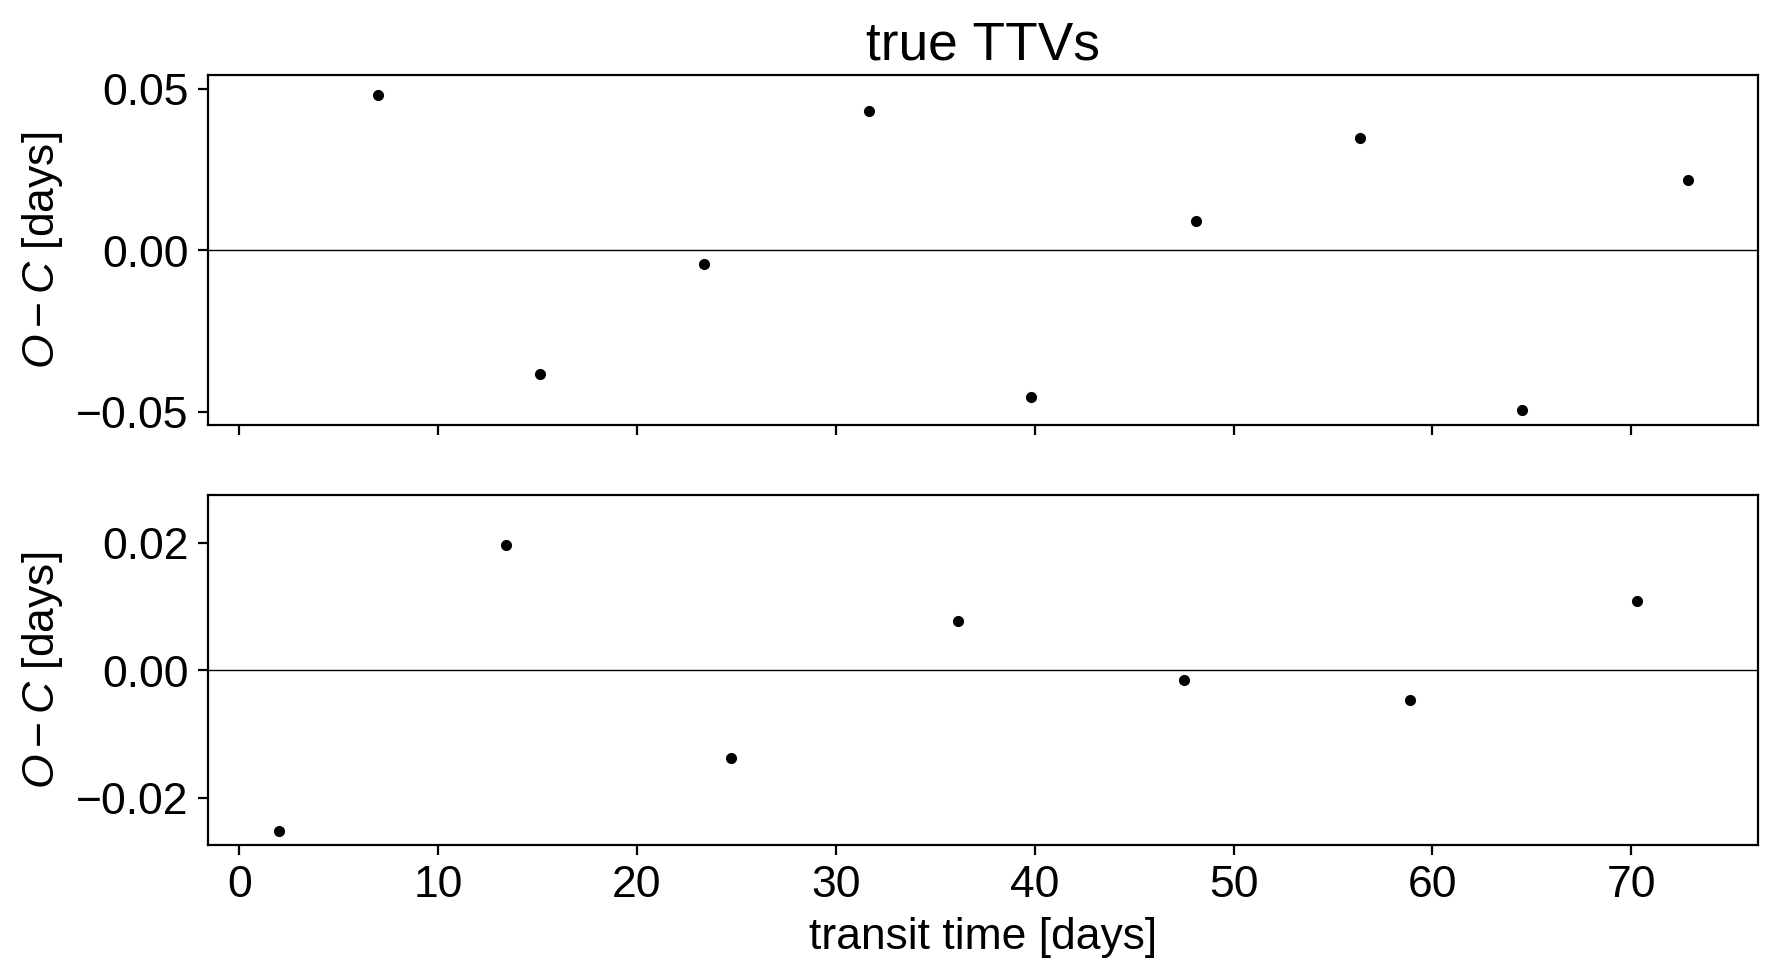

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

np.random.seed(3948)
true_periods = np.random.uniform(8, 12, 2)
true_t0s = true_periods * np.random.rand(2)
t = np.arange(0, 80, 0.01)
texp = 0.01
yerr = 5e-4

# Compute the transit times for a linear ephemeris
true_transit_times = xo.orbits.ttv.compute_expected_transit_times(
    t.min(), t.max(), true_periods, true_t0s
)

# Simulate transit timing variations using a simple model
true_ttvs = [
    (0.05 - (i % 2) * 0.1) * np.sin(2 * np.pi * tt / 23.7)
    for i, tt in enumerate(true_transit_times)
]
true_transit_times = [tt + v for tt, v in zip(true_transit_times, true_ttvs)]

# Plot the true TTV model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax1.plot(true_transit_times[0], true_ttvs[0], ".k")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))
ax1.set_ylabel("$O-C$ [days]")

ax2.plot(true_transit_times[1], true_ttvs[1], ".k")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))
ax2.set_ylabel("$O-C$ [days]")

ax2.set_xlabel("transit time [days]")
ax1.set_title("true TTVs");

Now, like in the :ref:`transit` tutorial, we'll set up the the model using `PyMC3` and `exoplanet`, and then simulate a data set from that model.

In [4]:
import pymc3 as pm
import theano.tensor as tt

np.random.seed(9485023)

with pm.Model() as model:

    # This part of the model is similar to the model in the `transit` tutorial
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    logr = pm.Uniform(
        "logr",
        lower=np.log(0.01),
        upper=np.log(0.1),
        shape=2,
        testval=np.log([0.04, 0.06]),
    )
    r = pm.Deterministic("r", tt.exp(logr))
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=0.5 * np.random.rand(2)
    )

    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(2):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=true_transit_times[i],
                sd=1.0,
                shape=len(true_transit_times[i]),
            )
        )

    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times)

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0)
    pm.Deterministic("period", orbit.period)
    for i in range(2):
        pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])

    # The rest of this block follows the transit fitting tutorial
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t, texp=texp
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curves", light_curves)
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    map_soln = model.test_point
    map_soln = xo.optimize(start=map_soln, vars=transit_times)
    map_soln = xo.optimize(start=map_soln, vars=[r, b])
    map_soln = xo.optimize(start=map_soln, vars=transit_times)
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [tts_1, tts_0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.945488e+04]

1it [00:00, 78.75it/s, logp=4.945488e+04]

2it [00:00, 110.59it/s, logp=4.945488e+04]

3it [00:00, 124.86it/s, logp=4.317367e+04]

4it [00:00, 139.22it/s, logp=4.919676e+04]

5it [00:00, 153.14it/s, logp=4.945996e+04]

6it [00:00, 161.24it/s, logp=4.944404e+04]

7it [00:00, 159.25it/s, logp=4.946088e+04]

8it [00:00, 158.30it/s, logp=4.946008e+04]

9it [00:00, 161.72it/s, logp=4.946120e+04]

10it [00:00, 166.94it/s, logp=4.945897e+04]

11it [00:00, 173.43it/s, logp=4.946124e+04]

12it [00:00, 179.37it/s, logp=4.946111e+04]

13it [00:00, 187.30it/s, logp=4.946124e+04]

14it [00:00, 195.15it/s, logp=4.946122e+04]

15it [00:00, 202.27it/s, logp=4.946124e+04]

16it [00:00, 208.13it/s, logp=4.946124e+04]

17it [00:00, 211.70it/s, logp=4.946124e+04]

18it [00:00, 210.69it/s, logp=4.946124e+04]

19it [00:00, 210.92it/s, logp=4.946124e+04]

20it [00:00, 211.46it/s, logp=4.946124e+04]

21it [00:00, 212.67it/s, logp=4.946124e+04]

22it [00:00, 215.32it/s, logp=4.946124e+04]

23it [00:00, 224.02it/s, logp=4.946124e+04]

23it [00:00, 224.02it/s, logp=4.946124e+04]

24it [00:00, 224.02it/s, logp=4.946124e+04]

25it [00:00, 224.02it/s, logp=4.946124e+04]

26it [00:00, 224.02it/s, logp=4.946124e+04]

27it [00:00, 224.02it/s, logp=4.946124e+04]

28it [00:00, 224.02it/s, logp=4.946124e+04]

29it [00:00, 224.02it/s, logp=4.946124e+04]

30it [00:00, 224.02it/s, logp=4.946124e+04]

31it [00:00, 224.02it/s, logp=4.946124e+04]

32it [00:00, 224.02it/s, logp=4.946125e+04]

33it [00:00, 224.02it/s, logp=4.946125e+04]

34it [00:00, 224.02it/s, logp=4.946126e+04]

35it [00:00, 224.02it/s, logp=4.946113e+04]

36it [00:00, 224.02it/s, logp=4.946126e+04]

37it [00:00, 224.02it/s, logp=4.946071e+04]

38it [00:00, 224.02it/s, logp=4.946126e+04]

39it [00:00, 224.02it/s, logp=4.946126e+04]

40it [00:00, 224.02it/s, logp=4.946126e+04]

41it [00:00, 224.02it/s, logp=4.946126e+04]

42it [00:00, 224.02it/s, logp=4.946126e+04]

43it [00:00, 224.02it/s, logp=4.946126e+04]

44it [00:00, 224.02it/s, logp=4.946127e+04]

45it [00:00, 224.02it/s, logp=4.946128e+04]

46it [00:00, 224.02it/s, logp=4.946128e+04]

47it [00:00, 227.72it/s, logp=4.946128e+04]

47it [00:00, 227.72it/s, logp=4.946128e+04]

48it [00:00, 227.72it/s, logp=4.946128e+04]

49it [00:00, 227.72it/s, logp=4.946128e+04]

50it [00:00, 227.72it/s, logp=4.946128e+04]

51it [00:00, 227.72it/s, logp=4.946128e+04]

52it [00:00, 227.72it/s, logp=4.946128e+04]

53it [00:00, 227.72it/s, logp=4.946128e+04]

54it [00:00, 227.72it/s, logp=4.946128e+04]

55it [00:00, 227.72it/s, logp=4.946128e+04]

56it [00:00, 227.72it/s, logp=4.946128e+04]

57it [00:00, 227.72it/s, logp=4.946128e+04]

58it [00:00, 227.72it/s, logp=4.946128e+04]

59it [00:00, 227.72it/s, logp=4.946128e+04]

60it [00:00, 227.72it/s, logp=4.946128e+04]

61it [00:00, 227.72it/s, logp=4.946128e+04]

62it [00:00, 227.72it/s, logp=4.946128e+04]

63it [00:00, 227.72it/s, logp=4.946128e+04]

64it [00:00, 227.72it/s, logp=4.946128e+04]

65it [00:00, 227.72it/s, logp=4.946128e+04]

66it [00:00, 227.72it/s, logp=4.946128e+04]

67it [00:00, 227.72it/s, logp=4.946128e+04]

68it [00:00, 227.72it/s, logp=4.946128e+04]

69it [00:00, 227.72it/s, logp=4.946128e+04]

70it [00:00, 227.72it/s, logp=4.946128e+04]

71it [00:00, 227.72it/s, logp=4.946128e+04]

72it [00:00, 227.72it/s, logp=4.946128e+04]

73it [00:00, 227.72it/s, logp=4.946128e+04]

74it [00:00, 227.72it/s, logp=4.946128e+04]

75it [00:00, 227.72it/s, logp=4.946128e+04]

76it [00:00, 227.72it/s, logp=4.946128e+04]

77it [00:00, 227.72it/s, logp=4.946128e+04]

78it [00:00, 227.72it/s, logp=4.946128e+04]

79it [00:00, 227.72it/s, logp=4.946128e+04]

80it [00:00, 227.72it/s, logp=4.946128e+04]

81it [00:00, 227.72it/s, logp=4.946128e+04]

82it [00:00, 227.72it/s, logp=4.946128e+04]

83it [00:00, 227.72it/s, logp=4.946128e+04]

84it [00:00, 227.72it/s, logp=4.946128e+04]

85it [00:00, 227.72it/s, logp=4.946128e+04]

86it [00:00, 227.72it/s, logp=4.946128e+04]

87it [00:00, 227.72it/s, logp=4.946128e+04]

88it [00:00, 227.72it/s, logp=4.946128e+04]

89it [00:00, 263.63it/s, logp=4.946128e+04]

89it [00:00, 263.63it/s, logp=4.946128e+04]

90it [00:00, 263.63it/s, logp=4.946128e+04]

91it [00:00, 263.63it/s, logp=4.946128e+04]

92it [00:00, 263.63it/s, logp=4.946128e+04]

93it [00:00, 263.63it/s, logp=4.946128e+04]

94it [00:00, 263.63it/s, logp=4.946128e+04]

95it [00:00, 263.63it/s, logp=4.946128e+04]

96it [00:00, 263.63it/s, logp=4.946128e+04]

97it [00:00, 263.63it/s, logp=4.946128e+04]

98it [00:00, 263.63it/s, logp=4.946128e+04]

99it [00:00, 263.63it/s, logp=4.946128e+04]

100it [00:00, 263.63it/s, logp=4.946128e+04]

101it [00:00, 263.63it/s, logp=4.946128e+04]

102it [00:00, 263.63it/s, logp=4.946128e+04]

103it [00:00, 263.63it/s, logp=4.946128e+04]

104it [00:00, 263.63it/s, logp=4.946128e+04]

105it [00:00, 263.63it/s, logp=4.946128e+04]

106it [00:00, 263.63it/s, logp=4.946128e+04]

107it [00:00, 263.63it/s, logp=4.946128e+04]

108it [00:00, 263.63it/s, logp=4.946128e+04]

109it [00:00, 263.63it/s, logp=4.946128e+04]

110it [00:00, 263.63it/s, logp=4.946128e+04]

111it [00:00, 263.63it/s, logp=4.946128e+04]

112it [00:00, 263.63it/s, logp=4.946128e+04]

113it [00:00, 263.63it/s, logp=4.946128e+04]

114it [00:00, 263.63it/s, logp=4.946128e+04]

115it [00:00, 263.63it/s, logp=4.946128e+04]

116it [00:00, 263.63it/s, logp=4.946128e+04]

117it [00:00, 263.63it/s, logp=4.946128e+04]

118it [00:00, 263.63it/s, logp=4.946128e+04]

119it [00:00, 263.63it/s, logp=4.946128e+04]

120it [00:00, 263.63it/s, logp=4.946128e+04]

121it [00:00, 263.63it/s, logp=4.946128e+04]

122it [00:00, 263.63it/s, logp=4.946128e+04]

123it [00:00, 263.63it/s, logp=4.946128e+04]

124it [00:00, 263.63it/s, logp=4.946128e+04]

125it [00:00, 263.63it/s, logp=4.946128e+04]

126it [00:00, 263.63it/s, logp=4.946128e+04]

127it [00:05, 24.93it/s, logp=4.946128e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 49454.87884962603 -> 49461.28172640353


optimizing logp for variables: [b, logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946128e+04]

1it [00:00, 115.67it/s, logp=4.946128e+04]

2it [00:00, 148.51it/s, logp=4.946128e+04]

3it [00:00, 158.66it/s, logp=4.877899e+04]

4it [00:00, 174.56it/s, logp=4.946162e+04]

5it [00:00, 184.59it/s, logp=4.946226e+04]

6it [00:00, 191.92it/s, logp=4.946182e+04]

7it [00:00, 191.46it/s, logp=4.946249e+04]

8it [00:00, 192.70it/s, logp=4.946224e+04]

9it [00:00, 195.80it/s, logp=4.946258e+04]

10it [00:00, 203.66it/s, logp=4.946275e+04]

11it [00:00, 213.48it/s, logp=4.946327e+04]

12it [00:00, 221.19it/s, logp=4.946356e+04]

13it [00:00, 226.58it/s, logp=4.946356e+04]

14it [00:00, 234.12it/s, logp=4.946356e+04]

15it [00:00, 241.29it/s, logp=4.946356e+04]

16it [00:00, 248.12it/s, logp=4.946356e+04]

17it [00:00, 254.57it/s, logp=4.946356e+04]

18it [00:00, 20.89it/s, logp=4.946356e+04] 


message: Optimization terminated successfully.
logp: 49461.28172640353 -> 49463.562186172574


optimizing logp for variables: [tts_1, tts_0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946356e+04]

1it [00:00, 206.71it/s, logp=4.946356e+04]

2it [00:00, 286.48it/s, logp=4.946356e+04]

3it [00:00, 317.20it/s, logp=4.419105e+04]

4it [00:00, 335.92it/s, logp=4.944272e+04]

5it [00:00, 351.86it/s, logp=4.946361e+04]

6it [00:00, 357.26it/s, logp=4.946308e+04]

7it [00:00, 363.53it/s, logp=4.946362e+04]

8it [00:00, 366.68it/s, logp=4.946362e+04]

9it [00:00, 368.74it/s, logp=4.946351e+04]

10it [00:00, 372.61it/s, logp=4.946362e+04]

11it [00:00, 370.74it/s, logp=4.946362e+04]

12it [00:00, 372.62it/s, logp=4.946362e+04]

13it [00:00, 372.31it/s, logp=4.946362e+04]

14it [00:00, 374.59it/s, logp=4.946362e+04]

15it [00:00, 374.62it/s, logp=4.946362e+04]

16it [00:00, 376.46it/s, logp=4.946362e+04]

17it [00:00, 377.40it/s, logp=4.946362e+04]

18it [00:00, 380.29it/s, logp=4.946362e+04]

19it [00:00, 381.53it/s, logp=4.946362e+04]

20it [00:00, 383.75it/s, logp=4.946362e+04]

21it [00:00, 384.26it/s, logp=4.946362e+04]

22it [00:00, 384.29it/s, logp=4.946362e+04]

23it [00:00, 383.80it/s, logp=4.946362e+04]

24it [00:00, 385.30it/s, logp=4.946362e+04]

25it [00:00, 386.60it/s, logp=4.946362e+04]

26it [00:00, 386.59it/s, logp=4.946362e+04]

27it [00:00, 388.02it/s, logp=4.946362e+04]

28it [00:00, 389.33it/s, logp=4.946362e+04]

29it [00:00, 389.59it/s, logp=4.946363e+04]

30it [00:00, 387.79it/s, logp=4.946363e+04]

31it [00:00, 386.07it/s, logp=4.946332e+04]

32it [00:00, 385.12it/s, logp=4.946363e+04]

33it [00:00, 383.36it/s, logp=4.946363e+04]

34it [00:00, 382.47it/s, logp=4.946363e+04]

35it [00:00, 382.27it/s, logp=4.946363e+04]

36it [00:00, 382.47it/s, logp=4.946363e+04]

37it [00:00, 383.45it/s, logp=4.946363e+04]

38it [00:00, 384.14it/s, logp=4.946363e+04]

39it [00:00, 385.13it/s, logp=4.946363e+04]

40it [00:00, 392.97it/s, logp=4.946363e+04]

40it [00:00, 392.97it/s, logp=4.946309e+04]

41it [00:00, 392.97it/s, logp=4.946363e+04]

42it [00:00, 392.97it/s, logp=4.946363e+04]

43it [00:00, 392.97it/s, logp=4.946363e+04]

44it [00:00, 392.97it/s, logp=4.946363e+04]

45it [00:00, 392.97it/s, logp=4.946363e+04]

46it [00:00, 392.97it/s, logp=4.946363e+04]

47it [00:00, 392.97it/s, logp=4.946363e+04]

48it [00:00, 392.97it/s, logp=4.946363e+04]

49it [00:00, 392.97it/s, logp=4.946363e+04]

50it [00:00, 392.97it/s, logp=4.946363e+04]

51it [00:00, 392.97it/s, logp=4.946363e+04]

52it [00:00, 392.97it/s, logp=4.946363e+04]

53it [00:00, 392.97it/s, logp=4.946363e+04]

54it [00:00, 392.97it/s, logp=4.946363e+04]

55it [00:00, 392.97it/s, logp=4.946363e+04]

56it [00:00, 392.97it/s, logp=4.946363e+04]

57it [00:00, 392.97it/s, logp=4.946363e+04]

58it [00:00, 392.97it/s, logp=4.946363e+04]

59it [00:00, 392.97it/s, logp=4.946363e+04]

60it [00:00, 392.97it/s, logp=4.946363e+04]

61it [00:00, 392.97it/s, logp=4.946363e+04]

62it [00:00, 392.97it/s, logp=4.946363e+04]

63it [00:00, 392.97it/s, logp=4.946363e+04]

64it [00:00, 392.97it/s, logp=4.946363e+04]

65it [00:00, 392.97it/s, logp=4.946363e+04]

66it [00:00, 392.97it/s, logp=4.946363e+04]

67it [00:00, 392.97it/s, logp=4.946363e+04]

68it [00:00, 392.97it/s, logp=4.946363e+04]

69it [00:00, 392.97it/s, logp=4.946363e+04]

70it [00:00, 392.97it/s, logp=4.946363e+04]

71it [00:00, 392.97it/s, logp=4.946363e+04]

72it [00:00, 392.97it/s, logp=4.946363e+04]

73it [00:00, 369.98it/s, logp=4.946363e+04]

73it [00:00, 369.98it/s, logp=4.946363e+04]

74it [00:00, 369.98it/s, logp=4.946363e+04]

75it [00:00, 369.98it/s, logp=4.946363e+04]

76it [00:00, 369.98it/s, logp=4.946363e+04]

77it [00:00, 369.98it/s, logp=4.946363e+04]

78it [00:00, 369.98it/s, logp=4.946363e+04]

79it [00:00, 369.98it/s, logp=4.946363e+04]

80it [00:00, 369.98it/s, logp=4.946363e+04]

81it [00:00, 369.98it/s, logp=4.946363e+04]

82it [00:00, 369.98it/s, logp=4.946363e+04]

83it [00:00, 369.98it/s, logp=4.946363e+04]

84it [00:00, 369.98it/s, logp=4.946363e+04]

85it [00:00, 369.98it/s, logp=4.946363e+04]

86it [00:00, 369.98it/s, logp=4.946363e+04]

87it [00:00, 369.98it/s, logp=4.946363e+04]

88it [00:00, 369.98it/s, logp=4.946363e+04]

89it [00:00, 369.98it/s, logp=4.946363e+04]

90it [00:00, 369.98it/s, logp=4.946363e+04]

91it [00:00, 369.98it/s, logp=4.946363e+04]

92it [00:00, 369.98it/s, logp=4.946363e+04]

93it [00:00, 369.98it/s, logp=4.946363e+04]

94it [00:00, 369.98it/s, logp=4.946363e+04]

95it [00:00, 369.98it/s, logp=4.946363e+04]

96it [00:00, 369.98it/s, logp=4.946363e+04]

97it [00:00, 369.98it/s, logp=4.946363e+04]

98it [00:00, 369.98it/s, logp=4.946363e+04]

99it [00:00, 369.98it/s, logp=4.946363e+04]

100it [00:00, 369.98it/s, logp=4.946363e+04]

101it [00:00, 369.98it/s, logp=4.946363e+04]

102it [00:00, 369.98it/s, logp=4.946363e+04]

103it [00:00, 369.98it/s, logp=4.946363e+04]

104it [00:00, 369.98it/s, logp=4.946363e+04]

105it [00:00, 351.01it/s, logp=4.946363e+04]

105it [00:00, 351.01it/s, logp=4.946363e+04]

106it [00:00, 351.01it/s, logp=4.946363e+04]

107it [00:00, 351.01it/s, logp=4.946363e+04]

108it [00:00, 351.01it/s, logp=4.946363e+04]

109it [00:00, 351.01it/s, logp=4.946363e+04]

110it [00:00, 351.01it/s, logp=4.946363e+04]

111it [00:00, 351.01it/s, logp=4.946363e+04]

112it [00:00, 351.01it/s, logp=4.946363e+04]

113it [00:00, 351.01it/s, logp=4.946363e+04]

114it [00:00, 351.01it/s, logp=4.946363e+04]

115it [00:00, 351.01it/s, logp=4.946363e+04]

116it [00:00, 351.01it/s, logp=4.946363e+04]

117it [00:00, 351.01it/s, logp=4.946363e+04]

118it [00:00, 351.01it/s, logp=4.946363e+04]

119it [00:00, 351.01it/s, logp=4.946363e+04]

120it [00:00, 351.01it/s, logp=4.946363e+04]

121it [00:01, 83.55it/s, logp=4.946363e+04] 


message: Optimization terminated successfully.
logp: 49463.562186172574 -> 49463.62677318628


optimizing logp for variables: [tts_1, tts_0, b, logr, u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946363e+04]

1it [00:00, 167.67it/s, logp=4.946363e+04]

2it [00:00, 231.81it/s, logp=4.946363e+04]

3it [00:00, 263.14it/s, logp=-1.632146e+10]

4it [00:00, 284.62it/s, logp=4.946375e+04] 

5it [00:00, 295.08it/s, logp=4.945886e+04]

6it [00:00, 305.16it/s, logp=4.946375e+04]

7it [00:00, 311.13it/s, logp=4.946373e+04]

8it [00:00, 319.21it/s, logp=4.946375e+04]

9it [00:00, 322.40it/s, logp=4.946375e+04]

10it [00:00, 327.75it/s, logp=4.946375e+04]

11it [00:00, 328.80it/s, logp=4.946375e+04]

12it [00:00, 331.80it/s, logp=4.946375e+04]

13it [00:00, 331.73it/s, logp=4.946375e+04]

14it [00:00, 333.34it/s, logp=4.946375e+04]

15it [00:00, 333.02it/s, logp=4.946375e+04]

16it [00:00, 334.20it/s, logp=4.946375e+04]

17it [00:00, 335.02it/s, logp=4.946375e+04]

18it [00:00, 335.00it/s, logp=4.946375e+04]

19it [00:00, 334.27it/s, logp=4.946375e+04]

20it [00:00, 333.91it/s, logp=4.946375e+04]

21it [00:00, 334.41it/s, logp=4.946375e+04]

22it [00:00, 334.22it/s, logp=4.946375e+04]

23it [00:00, 334.90it/s, logp=4.946375e+04]

24it [00:00, 335.45it/s, logp=4.946375e+04]

25it [00:00, 336.86it/s, logp=4.946375e+04]

26it [00:00, 338.75it/s, logp=4.946375e+04]

27it [00:00, 341.40it/s, logp=4.946375e+04]

28it [00:00, 343.14it/s, logp=4.946375e+04]

29it [00:00, 344.97it/s, logp=4.946367e+04]

30it [00:00, 347.58it/s, logp=4.946375e+04]

31it [00:00, 349.72it/s, logp=4.946375e+04]

32it [00:00, 352.77it/s, logp=4.946375e+04]

33it [00:00, 355.29it/s, logp=4.946375e+04]

34it [00:00, 356.37it/s, logp=4.946375e+04]

35it [00:00, 357.27it/s, logp=4.946374e+04]

36it [00:00, 359.16it/s, logp=4.946375e+04]

37it [00:00, 367.36it/s, logp=4.946375e+04]

37it [00:00, 367.36it/s, logp=4.946375e+04]

38it [00:00, 367.36it/s, logp=4.946375e+04]

39it [00:00, 367.36it/s, logp=4.946376e+04]

40it [00:00, 367.36it/s, logp=4.946377e+04]

41it [00:00, 367.36it/s, logp=4.946382e+04]

42it [00:00, 367.36it/s, logp=4.946230e+04]

43it [00:00, 367.36it/s, logp=4.946383e+04]

44it [00:00, 367.36it/s, logp=4.946383e+04]

45it [00:00, 367.36it/s, logp=4.946386e+04]

46it [00:00, 367.36it/s, logp=4.946392e+04]

47it [00:00, 367.36it/s, logp=4.946400e+04]

48it [00:00, 367.36it/s, logp=4.946400e+04]

49it [00:00, 367.36it/s, logp=4.946400e+04]

50it [00:00, 367.36it/s, logp=4.946400e+04]

51it [00:00, 367.36it/s, logp=4.946400e+04]

52it [00:00, 367.36it/s, logp=4.946400e+04]

53it [00:00, 367.36it/s, logp=4.946400e+04]

54it [00:00, 367.36it/s, logp=4.946400e+04]

55it [00:00, 367.36it/s, logp=4.946400e+04]

56it [00:00, 367.36it/s, logp=4.946400e+04]

57it [00:00, 367.36it/s, logp=4.946400e+04]

58it [00:00, 367.36it/s, logp=4.946400e+04]

59it [00:00, 367.36it/s, logp=4.946400e+04]

60it [00:00, 367.36it/s, logp=4.946400e+04]

61it [00:00, 367.36it/s, logp=4.946400e+04]

62it [00:00, 62.03it/s, logp=4.946400e+04] 


message: Optimization terminated successfully.
logp: 49463.62677318628 -> 49464.00471878114


Here's our simulated light curve and the initial model:

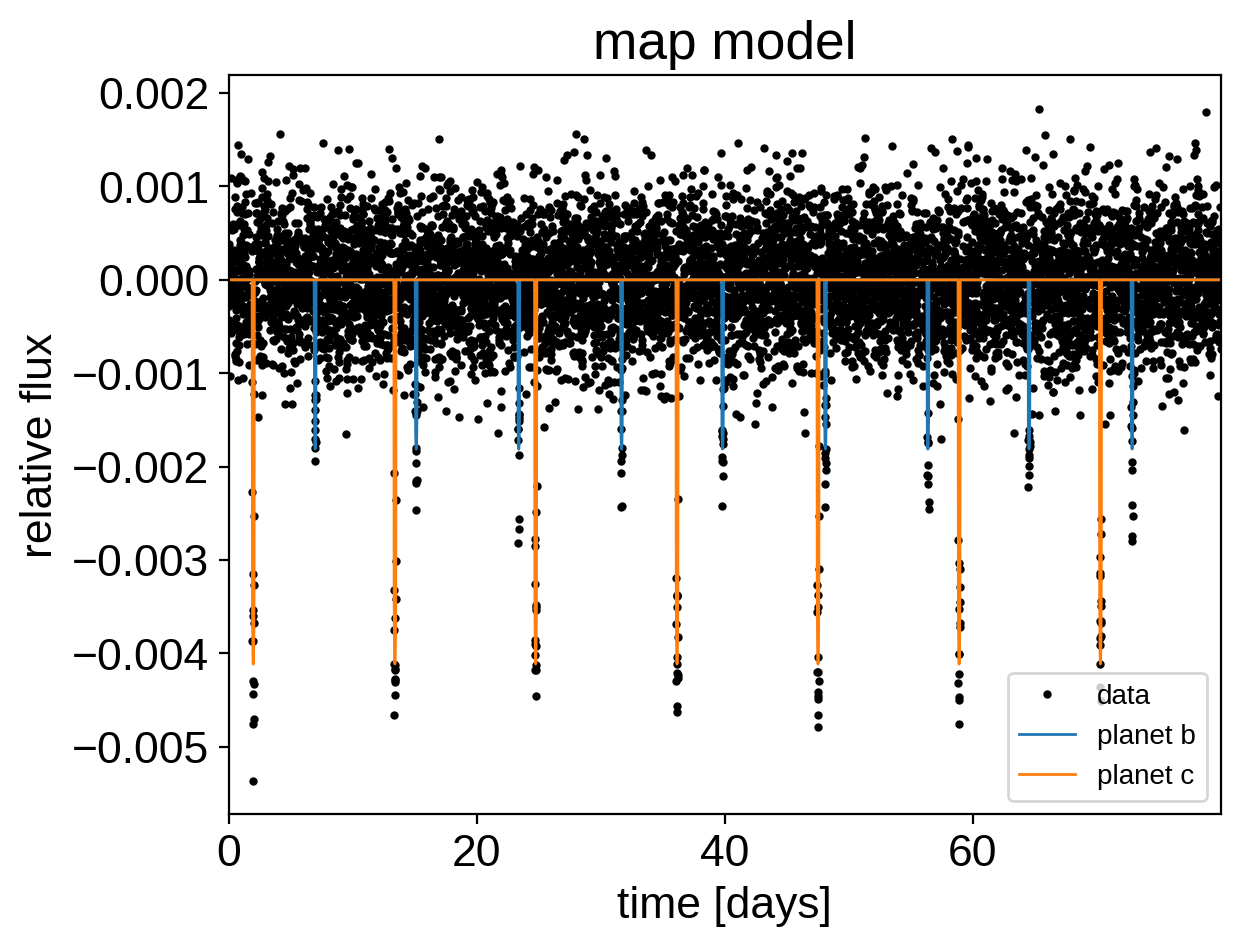

In [5]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

This looks similar to the light curve from the :ref:`transit` tutorial, but if we try plotting the folded transits, we can see that something isn't right: these transits look pretty smeared out!

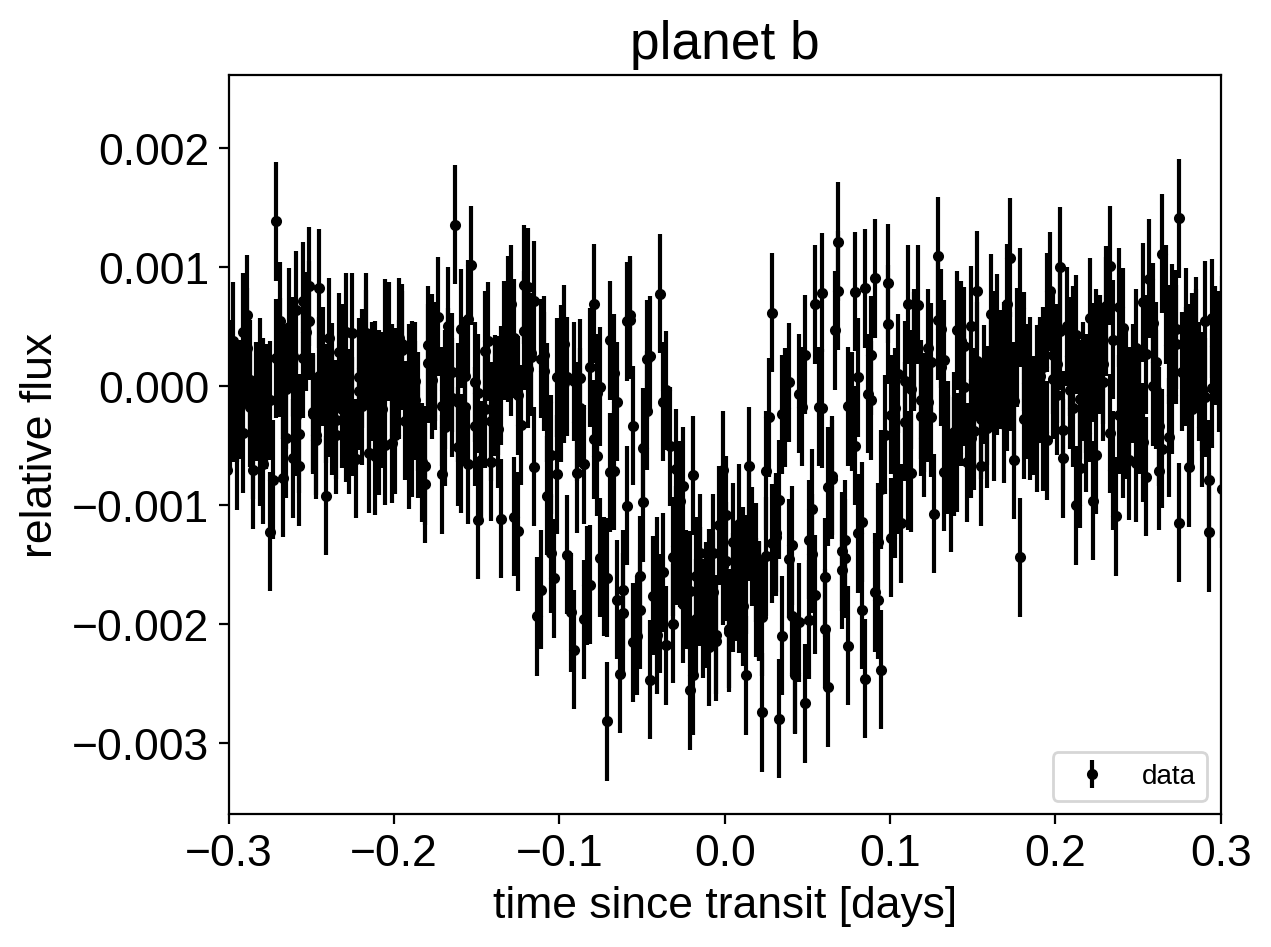

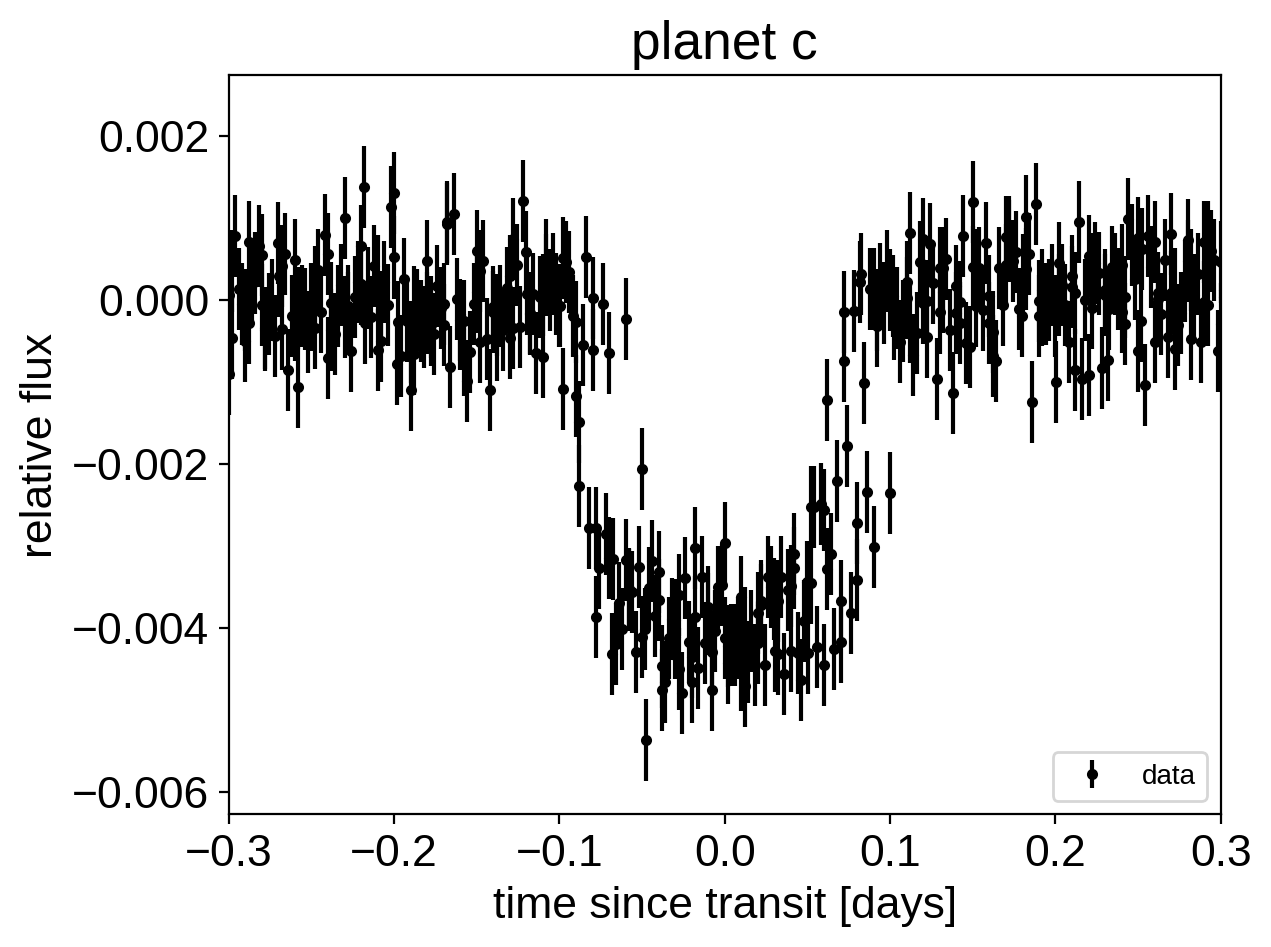

In [6]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = map_soln["period"][n]
    t0 = map_soln["t0"][n]

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = map_soln["light_curves"][:, (n + 1) % 2]

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

Instead, we can correct for the transit times by removing the best fit transit times and plot that instead:

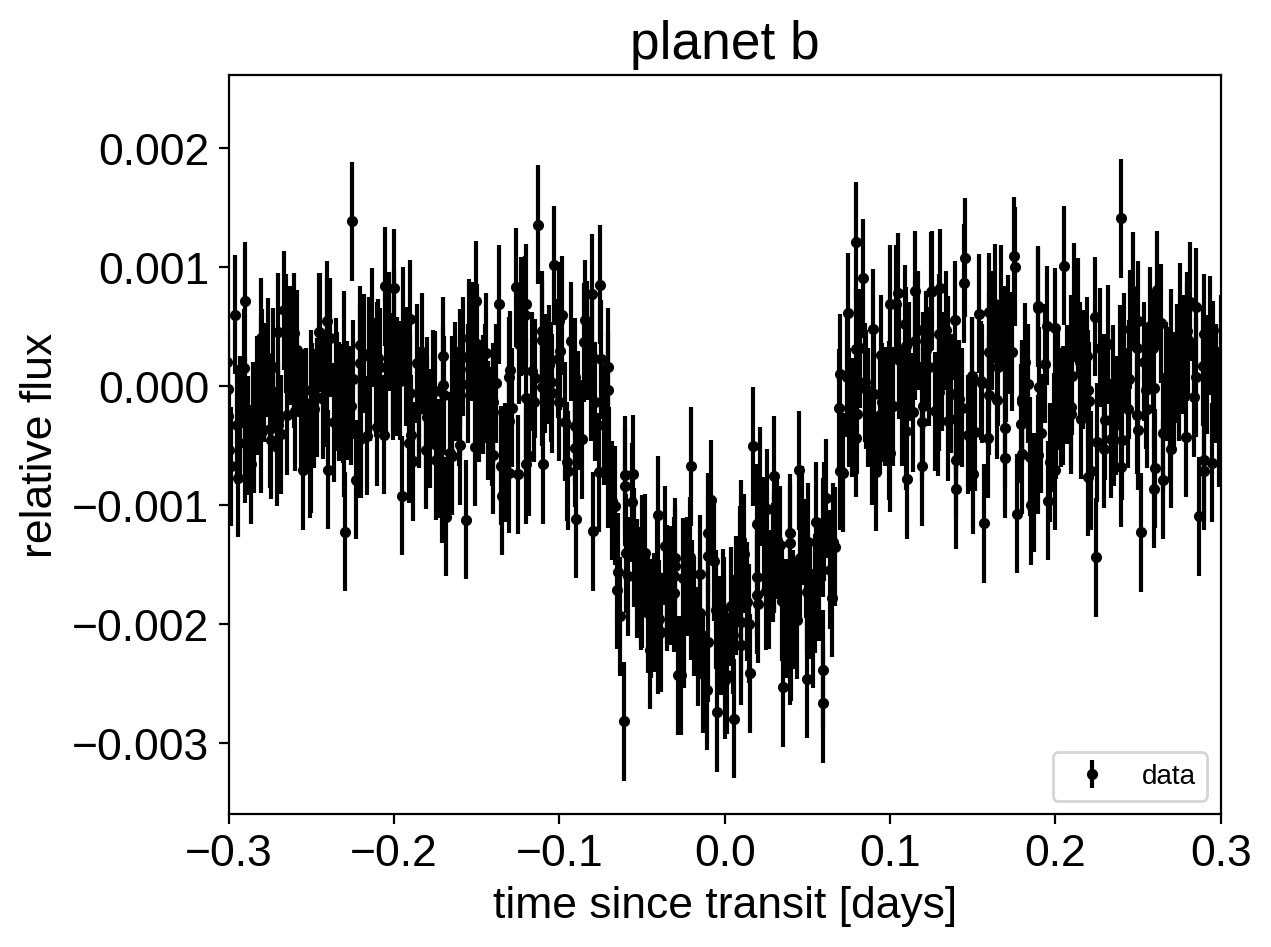

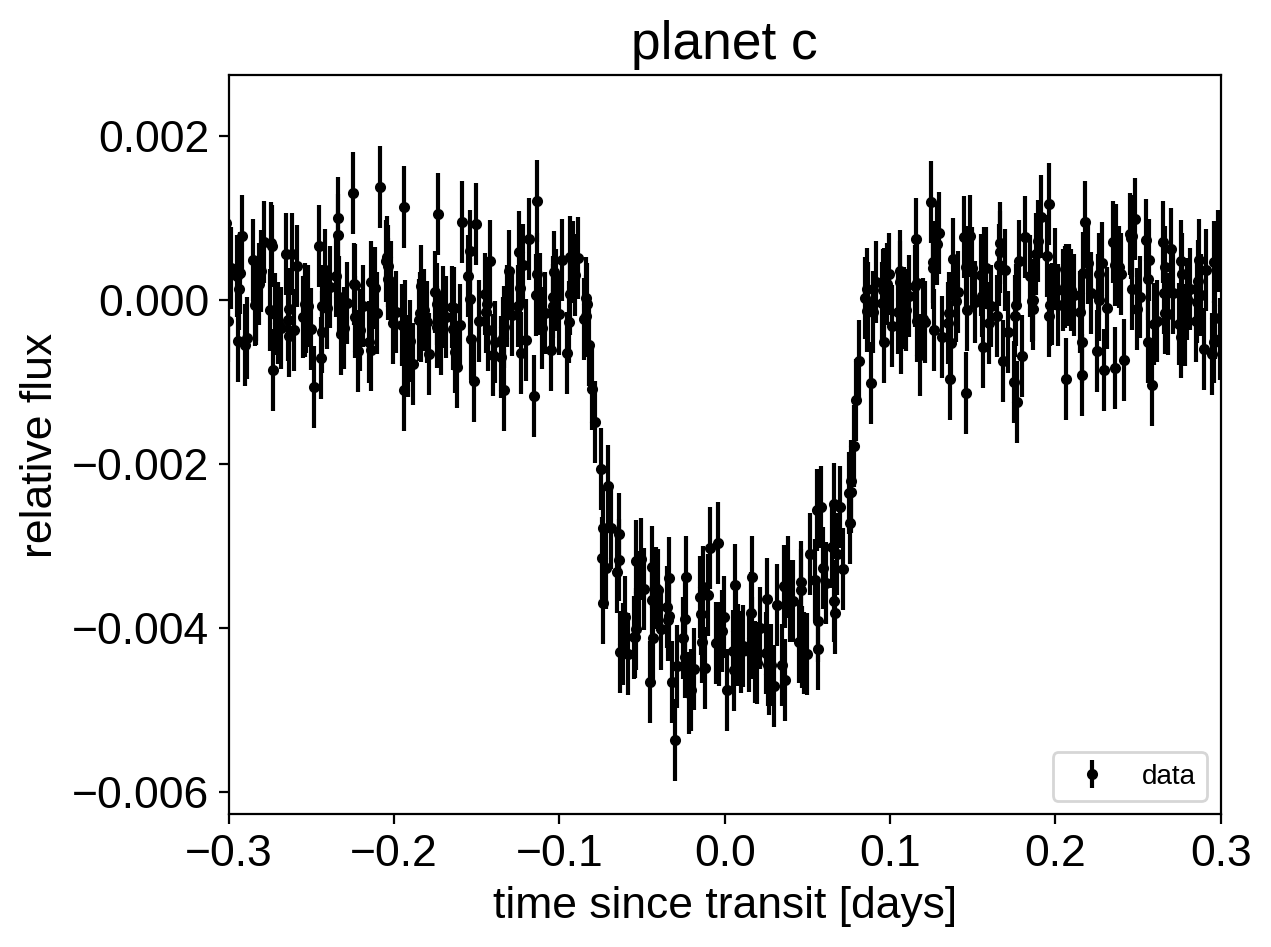

In [7]:
with model:
    t_warp = xo.eval_in_model(orbit._warp_times(t), map_soln)

for n, letter in enumerate("bc"):
    plt.figure()

    p = map_soln["period"][n]
    other = map_soln["light_curves"][:, (n + 1) % 2]

    # NOTE: 't0' has already been subtracted!
    x_fold = (t_warp[:, n] + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

That looks better!

## Sampling

Now let's run some MCMC as usual:

In [8]:
np.random.seed(230948)
with model:
    trace = xo.sample(tune=1000, draws=1000, start=map_soln)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [tts_1, tts_0, b, logr, u, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 21/8000 [00:00<02:54, 45.71draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/8000 [00:00<06:40, 19.91draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 28/8000 [00:01<06:10, 21.49draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 30/8000 [00:01<12:32, 10.59draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 32/8000 [00:01<11:18, 11.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 34/8000 [00:01<13:52,  9.57draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 36/8000 [00:02<13:57,  9.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 38/8000 [00:02<14:56,  8.88draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 40/8000 [00:02<14:48,  8.96draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 42/8000 [00:02<14:22,  9.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 44/8000 [00:03<15:44,  8.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 46/8000 [00:03<14:15,  9.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 48/8000 [00:03<15:53,  8.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 49/8000 [00:03<17:19,  7.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 51/8000 [00:03<14:18,  9.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 53/8000 [00:04<16:17,  8.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 54/8000 [00:04<17:58,  7.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 56/8000 [00:04<17:31,  7.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 58/8000 [00:04<17:41,  7.48draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 60/8000 [00:04<15:46,  8.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 62/8000 [00:05<17:18,  7.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 64/8000 [00:05<16:50,  7.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 66/8000 [00:05<16:58,  7.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 68/8000 [00:05<15:16,  8.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 71/8000 [00:06<12:06, 10.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 73/8000 [00:06<15:46,  8.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 75/8000 [00:06<13:05, 10.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 77/8000 [00:06<17:31,  7.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 80/8000 [00:07<16:33,  7.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 82/8000 [00:07<14:32,  9.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 84/8000 [00:07<16:40,  7.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 85/8000 [00:07<16:36,  7.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 87/8000 [00:08<14:57,  8.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 89/8000 [00:08<14:16,  9.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 91/8000 [00:08<12:30, 10.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 93/8000 [00:08<15:22,  8.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 95/8000 [00:08<13:08, 10.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 97/8000 [00:09<17:20,  7.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 99/8000 [00:09<14:19,  9.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 101/8000 [00:09<17:40,  7.45draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 103/8000 [00:09<14:41,  8.96draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 105/8000 [00:10<17:34,  7.49draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 107/8000 [00:10<14:51,  8.85draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 109/8000 [00:10<17:05,  7.70draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 110/8000 [00:10<18:01,  7.29draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 113/8000 [00:11<17:23,  7.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 114/8000 [00:11<16:43,  7.86draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 116/8000 [00:11<14:01,  9.37draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 118/8000 [00:11<17:50,  7.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 121/8000 [00:11<14:02,  9.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 123/8000 [00:12<17:02,  7.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 125/8000 [00:12<15:01,  8.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 127/8000 [00:12<16:48,  7.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 129/8000 [00:12<14:19,  9.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 132/8000 [00:13<15:17,  8.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 135/8000 [00:13<12:46, 10.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 137/8000 [00:13<16:49,  7.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 139/8000 [00:14<14:45,  8.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 141/8000 [00:14<16:37,  7.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 142/8000 [00:14<15:39,  8.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 144/8000 [00:14<17:47,  7.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 146/8000 [00:15<16:10,  8.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 148/8000 [00:15<18:37,  7.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 150/8000 [00:15<15:17,  8.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 152/8000 [00:15<18:11,  7.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 155/8000 [00:16<16:24,  7.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 156/8000 [00:16<21:47,  6.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 159/8000 [00:16<18:16,  7.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 160/8000 [00:16<25:51,  5.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 163/8000 [00:17<20:38,  6.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 164/8000 [00:17<27:14,  4.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 167/8000 [00:17<20:55,  6.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 169/8000 [00:18<22:00,  5.93draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 171/8000 [00:18<17:42,  7.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 173/8000 [00:18<19:14,  6.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 175/8000 [00:18<16:34,  7.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 177/8000 [00:19<18:51,  6.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 179/8000 [00:19<15:23,  8.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 181/8000 [00:19<17:57,  7.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 183/8000 [00:19<14:52,  8.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 185/8000 [00:19<17:38,  7.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 187/8000 [00:20<15:29,  8.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 189/8000 [00:20<16:58,  7.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 190/8000 [00:20<20:44,  6.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 193/8000 [00:20<17:50,  7.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 196/8000 [00:21<15:40,  8.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 198/8000 [00:21<16:46,  7.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 201/8000 [00:21<14:17,  9.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 204/8000 [00:21<13:14,  9.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 206/8000 [00:22<13:37,  9.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 209/8000 [00:22<12:44, 10.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 211/8000 [00:22<13:11,  9.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 215/8000 [00:23<13:31,  9.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 219/8000 [00:23<14:26,  8.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 223/8000 [00:24<14:24,  9.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 227/8000 [00:24<15:03,  8.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 230/8000 [00:24<12:04, 10.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 232/8000 [00:25<17:26,  7.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 235/8000 [00:25<13:56,  9.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 237/8000 [00:25<16:48,  7.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 239/8000 [00:25<14:13,  9.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 241/8000 [00:26<15:57,  8.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 243/8000 [00:26<13:20,  9.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 245/8000 [00:26<12:55, 10.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 247/8000 [00:26<14:12,  9.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 249/8000 [00:26<12:09, 10.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 251/8000 [00:26<11:02, 11.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 253/8000 [00:27<11:59, 10.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 255/8000 [00:27<11:57, 10.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 258/8000 [00:27<11:08, 11.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 260/8000 [00:27<12:45, 10.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 263/8000 [00:27<11:04, 11.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 266/8000 [00:28<12:54,  9.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 268/8000 [00:28<12:19, 10.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 270/8000 [00:28<12:10, 10.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 272/8000 [00:28<12:20, 10.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 275/8000 [00:29<10:51, 11.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 277/8000 [00:29<09:55, 12.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 279/8000 [00:29<09:51, 13.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 281/8000 [00:29<08:59, 14.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 284/8000 [00:29<07:53, 16.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 286/8000 [00:29<09:08, 14.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 288/8000 [00:29<10:18, 12.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 292/8000 [00:30<08:25, 15.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 296/8000 [00:30<07:14, 17.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 299/8000 [00:30<07:57, 16.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 302/8000 [00:30<07:05, 18.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 307/8000 [00:30<05:45, 22.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 311/8000 [00:30<05:01, 25.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 315/8000 [00:30<05:33, 23.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 318/8000 [00:31<07:51, 16.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 322/8000 [00:31<06:33, 19.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 325/8000 [00:31<06:18, 20.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 330/8000 [00:31<05:16, 24.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 336/8000 [00:31<04:20, 29.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 340/8000 [00:31<04:19, 29.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 345/8000 [00:31<03:48, 33.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 350/8000 [00:32<04:02, 31.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 354/8000 [00:32<03:50, 33.22draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 361/8000 [00:32<03:24, 37.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 366/8000 [00:32<03:18, 38.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 371/8000 [00:32<03:53, 32.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 375/8000 [00:32<03:54, 32.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 380/8000 [00:32<03:32, 35.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 384/8000 [00:33<03:31, 36.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 388/8000 [00:33<04:31, 28.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 392/8000 [00:33<05:17, 23.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 395/8000 [00:33<05:22, 23.55draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 403/8000 [00:33<04:21, 29.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 408/8000 [00:33<03:51, 32.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 414/8000 [00:33<03:25, 36.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 420/8000 [00:34<03:10, 39.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 425/8000 [00:34<03:01, 41.72draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 431/8000 [00:34<02:52, 43.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 439/8000 [00:34<02:31, 49.93draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 445/8000 [00:34<02:47, 45.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 450/8000 [00:34<03:02, 41.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 456/8000 [00:34<02:46, 45.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 463/8000 [00:34<02:29, 50.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 471/8000 [00:35<02:15, 55.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 478/8000 [00:35<02:09, 58.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 485/8000 [00:35<02:03, 60.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 493/8000 [00:35<02:00, 62.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 500/8000 [00:35<01:56, 64.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 507/8000 [00:35<02:04, 60.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 514/8000 [00:35<01:59, 62.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 523/8000 [00:35<01:51, 67.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 533/8000 [00:35<01:43, 71.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 541/8000 [00:36<01:42, 72.63draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 553/8000 [00:36<01:32, 80.91draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 564/8000 [00:36<01:26, 86.03draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 573/8000 [00:36<01:31, 81.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 582/8000 [00:36<01:34, 78.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 591/8000 [00:36<01:34, 77.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 599/8000 [00:36<01:36, 76.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 607/8000 [00:36<01:39, 74.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 615/8000 [00:36<01:42, 72.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 625/8000 [00:37<01:35, 77.27draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 633/8000 [00:37<01:35, 77.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 641/8000 [00:37<01:34, 77.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 651/8000 [00:37<01:28, 82.90draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 660/8000 [00:37<01:31, 79.88draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 672/8000 [00:37<01:25, 85.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 687/8000 [00:37<01:14, 98.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 698/8000 [00:37<01:14, 97.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 709/8000 [00:37<01:12, 100.09draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 720/8000 [00:38<01:15, 96.41draws/s] 

Sampling 4 chains, 0 divergences:   9%|▉         | 730/8000 [00:38<01:15, 96.30draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 741/8000 [00:38<01:13, 99.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 752/8000 [00:38<01:11, 102.06draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 763/8000 [00:38<01:20, 90.15draws/s] 

Sampling 4 chains, 0 divergences:  10%|▉         | 773/8000 [00:38<01:30, 79.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 782/8000 [00:38<01:46, 67.74draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 792/8000 [00:38<01:37, 73.68draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 800/8000 [00:39<01:35, 75.05draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 811/8000 [00:39<01:27, 82.05draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 823/8000 [00:39<01:20, 89.66draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 833/8000 [00:39<01:18, 91.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 843/8000 [00:39<01:19, 89.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 856/8000 [00:39<01:12, 97.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 868/8000 [00:39<01:09, 102.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 881/8000 [00:39<01:05, 108.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 895/8000 [00:39<01:01, 115.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 909/8000 [00:40<00:58, 121.37draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 922/8000 [00:40<01:02, 113.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 935/8000 [00:40<01:02, 112.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 947/8000 [00:40<01:08, 103.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 958/8000 [00:40<01:09, 101.36draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 972/8000 [00:40<01:04, 108.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 984/8000 [00:40<01:08, 102.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 995/8000 [00:40<01:11, 98.58draws/s] 

Sampling 4 chains, 0 divergences:  13%|█▎        | 1007/8000 [00:41<01:11, 97.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1021/8000 [00:41<01:05, 106.12draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1032/8000 [00:41<01:07, 103.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1045/8000 [00:41<01:04, 107.94draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1057/8000 [00:41<01:02, 110.83draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1070/8000 [00:41<01:01, 111.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1083/8000 [00:41<00:59, 115.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1096/8000 [00:41<00:57, 119.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1109/8000 [00:41<00:58, 117.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1121/8000 [00:42<01:01, 111.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1135/8000 [00:42<00:59, 116.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1148/8000 [00:42<00:57, 118.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1160/8000 [00:42<00:58, 116.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 1175/8000 [00:42<00:54, 124.41draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 1188/8000 [00:42<00:55, 122.87draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 1201/8000 [00:42<00:55, 121.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 1216/8000 [00:42<00:52, 128.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 1230/8000 [00:42<00:52, 128.11draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1245/8000 [00:42<00:51, 130.70draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1261/8000 [00:43<00:48, 137.82draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1275/8000 [00:43<00:50, 133.61draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1289/8000 [00:43<00:50, 133.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 1303/8000 [00:43<00:51, 130.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 1318/8000 [00:43<00:50, 132.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1332/8000 [00:43<00:55, 119.55draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1345/8000 [00:43<00:54, 121.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1360/8000 [00:43<00:51, 128.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1376/8000 [00:43<00:48, 136.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1390/8000 [00:44<00:49, 132.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1404/8000 [00:44<00:50, 129.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1418/8000 [00:44<00:53, 123.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1431/8000 [00:44<00:56, 116.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1443/8000 [00:44<01:00, 108.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1458/8000 [00:44<00:57, 114.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1471/8000 [00:44<00:55, 118.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 1484/8000 [00:44<00:53, 121.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 1499/8000 [00:44<00:50, 127.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 1512/8000 [00:45<00:51, 127.13draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 1527/8000 [00:45<00:48, 132.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 1541/8000 [00:45<00:54, 118.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 1554/8000 [00:45<00:55, 115.33draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 1566/8000 [00:45<00:56, 114.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 1578/8000 [00:45<01:00, 105.33draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 1589/8000 [00:45<01:00, 106.07draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 1600/8000 [00:45<01:02, 101.76draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 1612/8000 [00:46<00:59, 106.50draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 1624/8000 [00:46<00:59, 107.80draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 1637/8000 [00:46<00:56, 112.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 1651/8000 [00:46<00:53, 118.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 1663/8000 [00:46<00:53, 118.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 1675/8000 [00:46<00:53, 117.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 1687/8000 [00:46<00:54, 116.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 1701/8000 [00:46<00:51, 121.92draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 1714/8000 [00:46<00:51, 122.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1727/8000 [00:46<00:51, 122.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1742/8000 [00:47<00:48, 129.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1756/8000 [00:47<00:47, 131.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1770/8000 [00:47<00:49, 125.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1783/8000 [00:47<00:52, 117.54draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1795/8000 [00:47<00:53, 116.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1807/8000 [00:47<00:54, 113.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1820/8000 [00:47<00:52, 117.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1832/8000 [00:47<00:56, 109.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1844/8000 [00:47<00:58, 105.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1856/8000 [00:48<00:57, 107.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1869/8000 [00:48<00:54, 111.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 1881/8000 [00:48<00:54, 113.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 1897/8000 [00:48<00:49, 123.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 1910/8000 [00:48<00:54, 112.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 1922/8000 [00:48<00:54, 111.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 1935/8000 [00:48<00:53, 113.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 1951/8000 [00:48<00:48, 124.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 1965/8000 [00:48<00:47, 127.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 1979/8000 [00:49<00:46, 128.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 1993/8000 [00:49<00:45, 131.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 2007/8000 [00:49<00:46, 130.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 2021/8000 [00:49<00:46, 128.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 2034/8000 [00:49<00:50, 119.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 2047/8000 [00:49<00:48, 121.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 2063/8000 [00:49<00:47, 125.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 2078/8000 [00:49<00:46, 127.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 2095/8000 [00:49<00:43, 136.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 2109/8000 [00:50<00:44, 133.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 2126/8000 [00:50<00:42, 138.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 2141/8000 [00:50<00:45, 129.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 2157/8000 [00:50<00:42, 136.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 2171/8000 [00:50<00:43, 135.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 2187/8000 [00:50<00:41, 141.10draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2202/8000 [00:50<00:42, 137.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2216/8000 [00:50<00:46, 124.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2231/8000 [00:50<00:44, 129.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2245/8000 [00:51<00:44, 128.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2259/8000 [00:51<00:45, 126.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2272/8000 [00:51<00:47, 119.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 2285/8000 [00:51<00:46, 122.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 2300/8000 [00:51<00:44, 128.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 2317/8000 [00:51<00:41, 137.63draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 2335/8000 [00:51<00:38, 146.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 2351/8000 [00:51<00:38, 146.57draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 2366/8000 [00:51<00:38, 144.73draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 2383/8000 [00:52<00:37, 148.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 2399/8000 [00:52<00:37, 148.80draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 2415/8000 [00:52<00:37, 149.99draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 2433/8000 [00:52<00:35, 155.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 2449/8000 [00:52<00:38, 144.10draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 2464/8000 [00:52<00:42, 129.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 2479/8000 [00:52<00:41, 132.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 2494/8000 [00:52<00:40, 134.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 2510/8000 [00:52<00:39, 138.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2527/8000 [00:53<00:37, 144.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2542/8000 [00:53<00:38, 143.32draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2558/8000 [00:53<00:37, 146.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2573/8000 [00:53<00:38, 140.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2588/8000 [00:53<00:38, 142.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2604/8000 [00:53<00:38, 141.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2619/8000 [00:53<00:39, 137.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2633/8000 [00:53<00:39, 134.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2648/8000 [00:53<00:38, 137.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2664/8000 [00:54<00:38, 139.52draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2679/8000 [00:54<00:38, 139.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 2694/8000 [00:54<00:38, 138.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 2708/8000 [00:54<00:38, 136.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 2725/8000 [00:54<00:36, 144.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 2740/8000 [00:54<00:38, 136.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 2754/8000 [00:54<00:39, 132.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 2769/8000 [00:54<00:38, 135.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 2783/8000 [00:54<00:39, 132.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 2797/8000 [00:55<00:38, 133.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 2811/8000 [00:55<00:42, 122.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 2825/8000 [00:55<00:41, 124.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 2840/8000 [00:55<00:41, 124.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 2853/8000 [00:55<00:41, 125.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 2866/8000 [00:55<00:42, 119.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 2879/8000 [00:55<00:42, 119.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 2892/8000 [00:55<00:42, 120.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 2906/8000 [00:55<00:41, 124.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 2922/8000 [00:56<00:38, 132.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 2937/8000 [00:56<00:36, 137.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 2956/8000 [00:56<00:34, 148.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 2972/8000 [00:56<00:33, 150.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 2988/8000 [00:56<00:33, 149.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3005/8000 [00:56<00:33, 148.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3021/8000 [00:56<00:33, 147.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3036/8000 [00:56<00:34, 144.04draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3051/8000 [00:56<00:35, 140.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3066/8000 [00:57<00:37, 133.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 3082/8000 [00:57<00:35, 138.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 3101/8000 [00:57<00:33, 147.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 3117/8000 [00:57<00:33, 145.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 3132/8000 [00:57<00:33, 144.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 3147/8000 [00:57<00:34, 138.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 3162/8000 [00:57<00:35, 135.47draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 3177/8000 [00:57<00:34, 138.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 3192/8000 [00:57<00:33, 141.42draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 3207/8000 [00:58<00:33, 142.16draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 3222/8000 [00:58<00:33, 143.56draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 3241/8000 [00:58<00:31, 152.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 3257/8000 [00:58<00:30, 153.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 3273/8000 [00:58<00:31, 148.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 3291/8000 [00:58<00:30, 156.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 3307/8000 [00:58<00:32, 144.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3322/8000 [00:58<00:32, 142.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3337/8000 [00:58<00:35, 132.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3351/8000 [00:59<00:34, 133.21draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3365/8000 [00:59<00:35, 130.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3379/8000 [00:59<00:37, 123.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3392/8000 [00:59<00:37, 123.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3405/8000 [00:59<00:37, 123.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3420/8000 [00:59<00:36, 125.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3433/8000 [00:59<00:36, 123.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3446/8000 [00:59<00:36, 123.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3459/8000 [00:59<00:36, 124.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3475/8000 [01:00<00:35, 128.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 3491/8000 [01:00<00:33, 135.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 3505/8000 [01:00<00:32, 136.53draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 3521/8000 [01:00<00:31, 142.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 3536/8000 [01:00<00:31, 143.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 3552/8000 [01:00<00:30, 146.87draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 3567/8000 [01:00<00:30, 144.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 3584/8000 [01:00<00:29, 150.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 3600/8000 [01:00<00:29, 149.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 3616/8000 [01:00<00:29, 150.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 3634/8000 [01:01<00:27, 158.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 3650/8000 [01:01<00:28, 151.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 3666/8000 [01:01<00:29, 145.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 3681/8000 [01:01<00:31, 139.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 3696/8000 [01:01<00:32, 132.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 3710/8000 [01:01<00:32, 133.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3724/8000 [01:01<00:33, 126.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3738/8000 [01:01<00:33, 129.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3752/8000 [01:01<00:32, 131.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3766/8000 [01:02<00:32, 131.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3780/8000 [01:02<00:32, 129.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3793/8000 [01:02<00:35, 118.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3806/8000 [01:02<00:35, 116.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3822/8000 [01:02<00:34, 122.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3837/8000 [01:02<00:32, 128.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3853/8000 [01:02<00:30, 135.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3867/8000 [01:02<00:32, 126.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3880/8000 [01:02<00:32, 124.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 3893/8000 [01:03<00:32, 124.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 3908/8000 [01:03<00:31, 129.30draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 3923/8000 [01:03<00:30, 134.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 3937/8000 [01:03<00:30, 132.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 3951/8000 [01:03<00:32, 125.94draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 3966/8000 [01:03<00:30, 130.87draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 3983/8000 [01:03<00:28, 138.73draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 3998/8000 [01:03<00:30, 133.16draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 4013/8000 [01:03<00:29, 136.72draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 4028/8000 [01:04<00:28, 140.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 4043/8000 [01:04<00:28, 140.10draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 4058/8000 [01:04<00:30, 130.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 4072/8000 [01:04<00:29, 133.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 4086/8000 [01:04<00:30, 128.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 4101/8000 [01:04<00:29, 133.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 4115/8000 [01:04<00:28, 134.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4131/8000 [01:04<00:27, 139.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4146/8000 [01:04<00:27, 137.99draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4161/8000 [01:05<00:27, 139.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4176/8000 [01:05<00:27, 136.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4190/8000 [01:05<00:28, 134.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4204/8000 [01:05<00:28, 134.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4218/8000 [01:05<00:28, 133.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4232/8000 [01:05<00:29, 125.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4245/8000 [01:05<00:30, 124.30draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4259/8000 [01:05<00:29, 127.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4272/8000 [01:05<00:29, 127.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 4285/8000 [01:06<00:29, 125.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 4298/8000 [01:06<00:29, 123.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 4311/8000 [01:06<00:30, 122.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 4324/8000 [01:06<00:29, 122.64draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 4340/8000 [01:06<00:28, 128.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 4354/8000 [01:06<00:27, 131.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 4370/8000 [01:06<00:26, 136.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 4384/8000 [01:06<00:26, 135.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 4398/8000 [01:06<00:26, 134.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 4412/8000 [01:06<00:27, 132.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 4426/8000 [01:07<00:27, 129.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 4440/8000 [01:07<00:27, 129.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 4453/8000 [01:07<00:27, 128.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 4466/8000 [01:07<00:27, 128.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 4479/8000 [01:07<00:27, 128.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 4492/8000 [01:07<00:27, 128.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 4505/8000 [01:07<00:27, 128.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 4518/8000 [01:07<00:27, 127.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4532/8000 [01:07<00:27, 124.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4547/8000 [01:08<00:26, 129.65draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4561/8000 [01:08<00:26, 132.11draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4575/8000 [01:08<00:26, 128.55draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4588/8000 [01:08<00:27, 125.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4601/8000 [01:08<00:27, 125.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4616/8000 [01:08<00:26, 126.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4630/8000 [01:08<00:25, 130.25draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4644/8000 [01:08<00:25, 131.95draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4659/8000 [01:08<00:24, 136.04draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4673/8000 [01:08<00:24, 135.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 4687/8000 [01:09<00:24, 132.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 4701/8000 [01:09<00:24, 134.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 4715/8000 [01:09<00:25, 131.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 4730/8000 [01:09<00:24, 133.37draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 4744/8000 [01:09<00:24, 134.78draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 4758/8000 [01:09<00:24, 133.40draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 4773/8000 [01:09<00:24, 134.34draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 4787/8000 [01:09<00:24, 133.75draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 4801/8000 [01:09<00:24, 131.58draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 4817/8000 [01:10<00:23, 137.46draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 4831/8000 [01:10<00:23, 133.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 4845/8000 [01:10<00:23, 133.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 4859/8000 [01:10<00:23, 131.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 4874/8000 [01:10<00:23, 134.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 4888/8000 [01:10<00:22, 135.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 4903/8000 [01:10<00:23, 133.61draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 4919/8000 [01:10<00:22, 138.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4934/8000 [01:10<00:21, 140.38draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4949/8000 [01:11<00:21, 139.31draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4965/8000 [01:11<00:21, 144.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4980/8000 [01:11<00:20, 144.11draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4996/8000 [01:11<00:20, 146.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5012/8000 [01:11<00:20, 147.43draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5027/8000 [01:11<00:20, 142.93draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5042/8000 [01:11<00:21, 140.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5057/8000 [01:11<00:21, 135.32draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5073/8000 [01:11<00:20, 139.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 5088/8000 [01:12<00:20, 140.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 5103/8000 [01:12<00:21, 134.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 5117/8000 [01:12<00:22, 129.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 5131/8000 [01:12<00:21, 131.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 5145/8000 [01:12<00:21, 130.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 5159/8000 [01:12<00:22, 128.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 5173/8000 [01:12<00:21, 130.66draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 5187/8000 [01:12<00:21, 128.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 5203/8000 [01:12<00:21, 132.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 5217/8000 [01:13<00:20, 133.36draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 5232/8000 [01:13<00:20, 135.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 5246/8000 [01:13<00:20, 135.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 5261/8000 [01:13<00:19, 139.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 5275/8000 [01:13<00:19, 136.69draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 5289/8000 [01:13<00:20, 131.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 5303/8000 [01:13<00:20, 134.07draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 5318/8000 [01:13<00:19, 136.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 5334/8000 [01:13<00:19, 139.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 5348/8000 [01:13<00:19, 138.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 5362/8000 [01:14<00:19, 136.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 5376/8000 [01:14<00:19, 133.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 5390/8000 [01:14<00:20, 129.28draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5403/8000 [01:14<00:20, 127.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5417/8000 [01:14<00:20, 128.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5431/8000 [01:14<00:19, 130.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5445/8000 [01:14<00:19, 131.86draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5459/8000 [01:14<00:19, 130.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5474/8000 [01:14<00:18, 133.18draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 5488/8000 [01:15<00:19, 130.16draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 5502/8000 [01:15<00:19, 131.21draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 5516/8000 [01:15<00:19, 130.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 5531/8000 [01:15<00:19, 129.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 5546/8000 [01:15<00:18, 134.45draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 5561/8000 [01:15<00:18, 135.26draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 5575/8000 [01:15<00:18, 133.60draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 5589/8000 [01:15<00:18, 127.61draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 5602/8000 [01:15<00:19, 125.28draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 5615/8000 [01:16<00:19, 120.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 5630/8000 [01:16<00:19, 121.91draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 5645/8000 [01:16<00:18, 126.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 5660/8000 [01:16<00:17, 130.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 5675/8000 [01:16<00:17, 135.65draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 5691/8000 [01:16<00:16, 138.79draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 5706/8000 [01:16<00:16, 137.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5720/8000 [01:16<00:16, 134.70draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5734/8000 [01:16<00:16, 134.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5748/8000 [01:17<00:16, 135.72draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5762/8000 [01:17<00:16, 133.54draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5776/8000 [01:17<00:17, 129.19draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5789/8000 [01:17<00:17, 125.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5804/8000 [01:17<00:16, 131.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5818/8000 [01:17<00:16, 131.51draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5832/8000 [01:17<00:16, 133.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5846/8000 [01:17<00:16, 133.09draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5860/8000 [01:17<00:15, 134.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5875/8000 [01:17<00:15, 136.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 5890/8000 [01:18<00:15, 138.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 5905/8000 [01:18<00:15, 138.90draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 5920/8000 [01:18<00:15, 137.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 5935/8000 [01:18<00:15, 136.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 5950/8000 [01:18<00:14, 137.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 5965/8000 [01:18<00:14, 138.38draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 5981/8000 [01:18<00:14, 139.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 5996/8000 [01:18<00:14, 141.50draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 6011/8000 [01:18<00:13, 143.86draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 6026/8000 [01:19<00:13, 143.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 6041/8000 [01:19<00:13, 144.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 6056/8000 [01:19<00:14, 138.78draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 6071/8000 [01:19<00:13, 139.12draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 6085/8000 [01:19<00:13, 137.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 6099/8000 [01:19<00:14, 135.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 6113/8000 [01:19<00:14, 132.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6128/8000 [01:19<00:14, 133.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6142/8000 [01:19<00:14, 126.83draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6155/8000 [01:20<00:15, 122.54draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6169/8000 [01:20<00:14, 124.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6182/8000 [01:20<00:14, 124.24draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6195/8000 [01:20<00:14, 122.44draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6210/8000 [01:20<00:13, 129.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6224/8000 [01:20<00:13, 128.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6238/8000 [01:20<00:13, 128.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6251/8000 [01:20<00:13, 127.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6264/8000 [01:20<00:13, 126.44draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6278/8000 [01:20<00:13, 128.24draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 6292/8000 [01:21<00:13, 129.69draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 6306/8000 [01:21<00:12, 132.09draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 6320/8000 [01:21<00:12, 132.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 6335/8000 [01:21<00:12, 131.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 6350/8000 [01:21<00:12, 129.80draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 6365/8000 [01:21<00:12, 132.78draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 6379/8000 [01:21<00:12, 128.65draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 6392/8000 [01:21<00:12, 128.47draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 6406/8000 [01:21<00:12, 129.17draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 6421/8000 [01:22<00:11, 132.98draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 6435/8000 [01:22<00:12, 126.87draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 6448/8000 [01:22<00:12, 126.82draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 6463/8000 [01:22<00:11, 132.05draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 6479/8000 [01:22<00:10, 138.56draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 6495/8000 [01:22<00:10, 144.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 6511/8000 [01:22<00:10, 147.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6526/8000 [01:22<00:10, 147.23draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6542/8000 [01:22<00:09, 147.87draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6557/8000 [01:23<00:09, 146.58draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6572/8000 [01:23<00:10, 142.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6587/8000 [01:23<00:10, 141.27draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6602/8000 [01:23<00:10, 139.51draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6616/8000 [01:23<00:10, 136.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6630/8000 [01:23<00:10, 135.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6644/8000 [01:23<00:10, 134.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6659/8000 [01:23<00:09, 136.22draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6674/8000 [01:23<00:09, 135.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 6689/8000 [01:23<00:09, 138.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 6704/8000 [01:24<00:09, 138.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 6719/8000 [01:24<00:09, 133.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 6734/8000 [01:24<00:09, 134.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 6748/8000 [01:24<00:09, 136.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 6762/8000 [01:24<00:09, 135.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 6777/8000 [01:24<00:08, 137.12draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 6792/8000 [01:24<00:08, 140.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 6808/8000 [01:24<00:08, 139.87draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 6823/8000 [01:24<00:08, 141.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 6838/8000 [01:25<00:08, 141.49draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 6853/8000 [01:25<00:08, 142.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 6868/8000 [01:25<00:08, 138.11draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 6882/8000 [01:25<00:08, 134.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 6896/8000 [01:25<00:08, 134.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 6910/8000 [01:25<00:08, 130.60draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6924/8000 [01:25<00:08, 131.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6938/8000 [01:25<00:08, 130.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6952/8000 [01:25<00:08, 130.96draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6966/8000 [01:26<00:07, 132.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6981/8000 [01:26<00:07, 131.51draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6997/8000 [01:26<00:07, 133.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7012/8000 [01:26<00:07, 135.26draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7027/8000 [01:26<00:07, 137.69draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7041/8000 [01:26<00:07, 134.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7056/8000 [01:26<00:06, 136.03draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7071/8000 [01:26<00:06, 138.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 7085/8000 [01:26<00:06, 133.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 7099/8000 [01:27<00:06, 135.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 7113/8000 [01:27<00:06, 133.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 7128/8000 [01:27<00:06, 133.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 7144/8000 [01:27<00:06, 137.43draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 7159/8000 [01:27<00:05, 140.75draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 7174/8000 [01:27<00:05, 138.19draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 7188/8000 [01:27<00:06, 134.41draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 7205/8000 [01:27<00:05, 140.79draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 7221/8000 [01:27<00:05, 140.35draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 7236/8000 [01:27<00:05, 140.39draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 7251/8000 [01:28<00:05, 141.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 7266/8000 [01:28<00:05, 138.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 7280/8000 [01:28<00:05, 134.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 7294/8000 [01:28<00:05, 131.67draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 7308/8000 [01:28<00:05, 131.24draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7322/8000 [01:28<00:05, 130.07draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7336/8000 [01:28<00:05, 118.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7350/8000 [01:28<00:05, 123.21draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7365/8000 [01:29<00:04, 127.90draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7380/8000 [01:29<00:04, 133.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7395/8000 [01:29<00:04, 135.10draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7410/8000 [01:29<00:04, 137.02draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7425/8000 [01:29<00:04, 140.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7440/8000 [01:29<00:04, 133.06draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7454/8000 [01:29<00:04, 129.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7469/8000 [01:29<00:04, 128.36draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 7483/8000 [01:29<00:03, 129.86draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 7497/8000 [01:30<00:03, 127.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 7510/8000 [01:30<00:03, 123.91draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 7523/8000 [01:30<00:03, 125.30draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 7537/8000 [01:30<00:03, 125.77draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 7552/8000 [01:30<00:03, 128.44draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 7565/8000 [01:30<00:03, 128.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 7578/8000 [01:30<00:03, 127.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 7592/8000 [01:30<00:03, 125.87draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 7607/8000 [01:30<00:03, 130.62draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 7622/8000 [01:30<00:02, 132.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 7637/8000 [01:31<00:02, 137.55draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 7651/8000 [01:31<00:02, 129.98draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 7665/8000 [01:31<00:02, 130.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 7680/8000 [01:31<00:02, 134.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 7695/8000 [01:31<00:02, 138.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 7709/8000 [01:31<00:02, 135.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7723/8000 [01:31<00:02, 136.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7737/8000 [01:31<00:02, 129.08draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7751/8000 [01:31<00:02, 119.09draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7764/8000 [01:32<00:02, 113.10draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7776/8000 [01:32<00:01, 112.95draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7788/8000 [01:32<00:01, 110.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7800/8000 [01:32<00:01, 107.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7811/8000 [01:32<00:01, 101.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7822/8000 [01:32<00:01, 100.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7833/8000 [01:32<00:01, 102.30draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7845/8000 [01:32<00:01, 106.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7856/8000 [01:32<00:01, 103.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7867/8000 [01:33<00:01, 101.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7878/8000 [01:33<00:01, 102.77draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 7889/8000 [01:33<00:01, 94.92draws/s] 

Sampling 4 chains, 0 divergences:  99%|█████████▊| 7899/8000 [01:33<00:01, 90.06draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7909/8000 [01:33<00:01, 87.89draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7918/8000 [01:33<00:00, 83.16draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7927/8000 [01:33<00:00, 82.90draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7936/8000 [01:33<00:00, 83.19draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7945/8000 [01:34<00:00, 80.33draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7954/8000 [01:34<00:00, 80.99draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7964/8000 [01:34<00:00, 81.52draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7973/8000 [01:34<00:00, 83.22draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7982/8000 [01:34<00:00, 72.62draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7990/8000 [01:34<00:00, 60.86draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7997/8000 [01:34<00:00, 53.46draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [01:34<00:00, 84.23draws/s]

Then check the convergence diagnostics:

In [9]:
pm.summary(trace, var_names=["mean", "u", "logr", "b", "tts_0", "tts_1"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,-0.000,0.000,-0.000,0.000,0.000,0.000,8579.0,2531.0,8546.0,2858.0,1.0
u[0],0.343,0.172,0.004,0.603,0.003,0.002,3557.0,3488.0,3114.0,1777.0,1.0
u[1],0.178,0.298,-0.300,0.714,0.005,0.004,3121.0,2335.0,2781.0,2027.0,1.0
logr[0],-3.223,0.019,-3.259,-3.187,0.000,0.000,4273.0,4260.0,4411.0,2826.0,1.0
logr[1],-2.813,0.013,-2.839,-2.791,0.000,0.000,3494.0,3485.0,3770.0,2695.0,1.0
b[0],0.394,0.042,0.316,0.471,0.001,0.000,3604.0,3604.0,3882.0,2510.0,1.0
b[1],0.354,0.030,0.296,0.409,0.001,0.000,3178.0,3178.0,3854.0,2454.0,1.0
tts_0[0],6.963,0.005,6.955,6.972,0.000,0.000,4568.0,4567.0,5292.0,3082.0,1.0
tts_0[1],15.105,0.007,15.092,15.116,0.000,0.000,3004.0,3004.0,3631.0,3291.0,1.0
tts_0[2],23.380,0.002,23.376,23.385,0.000,0.000,6236.0,6236.0,6330.0,3334.0,1.0


And plot the corner plot of the physical parameters:

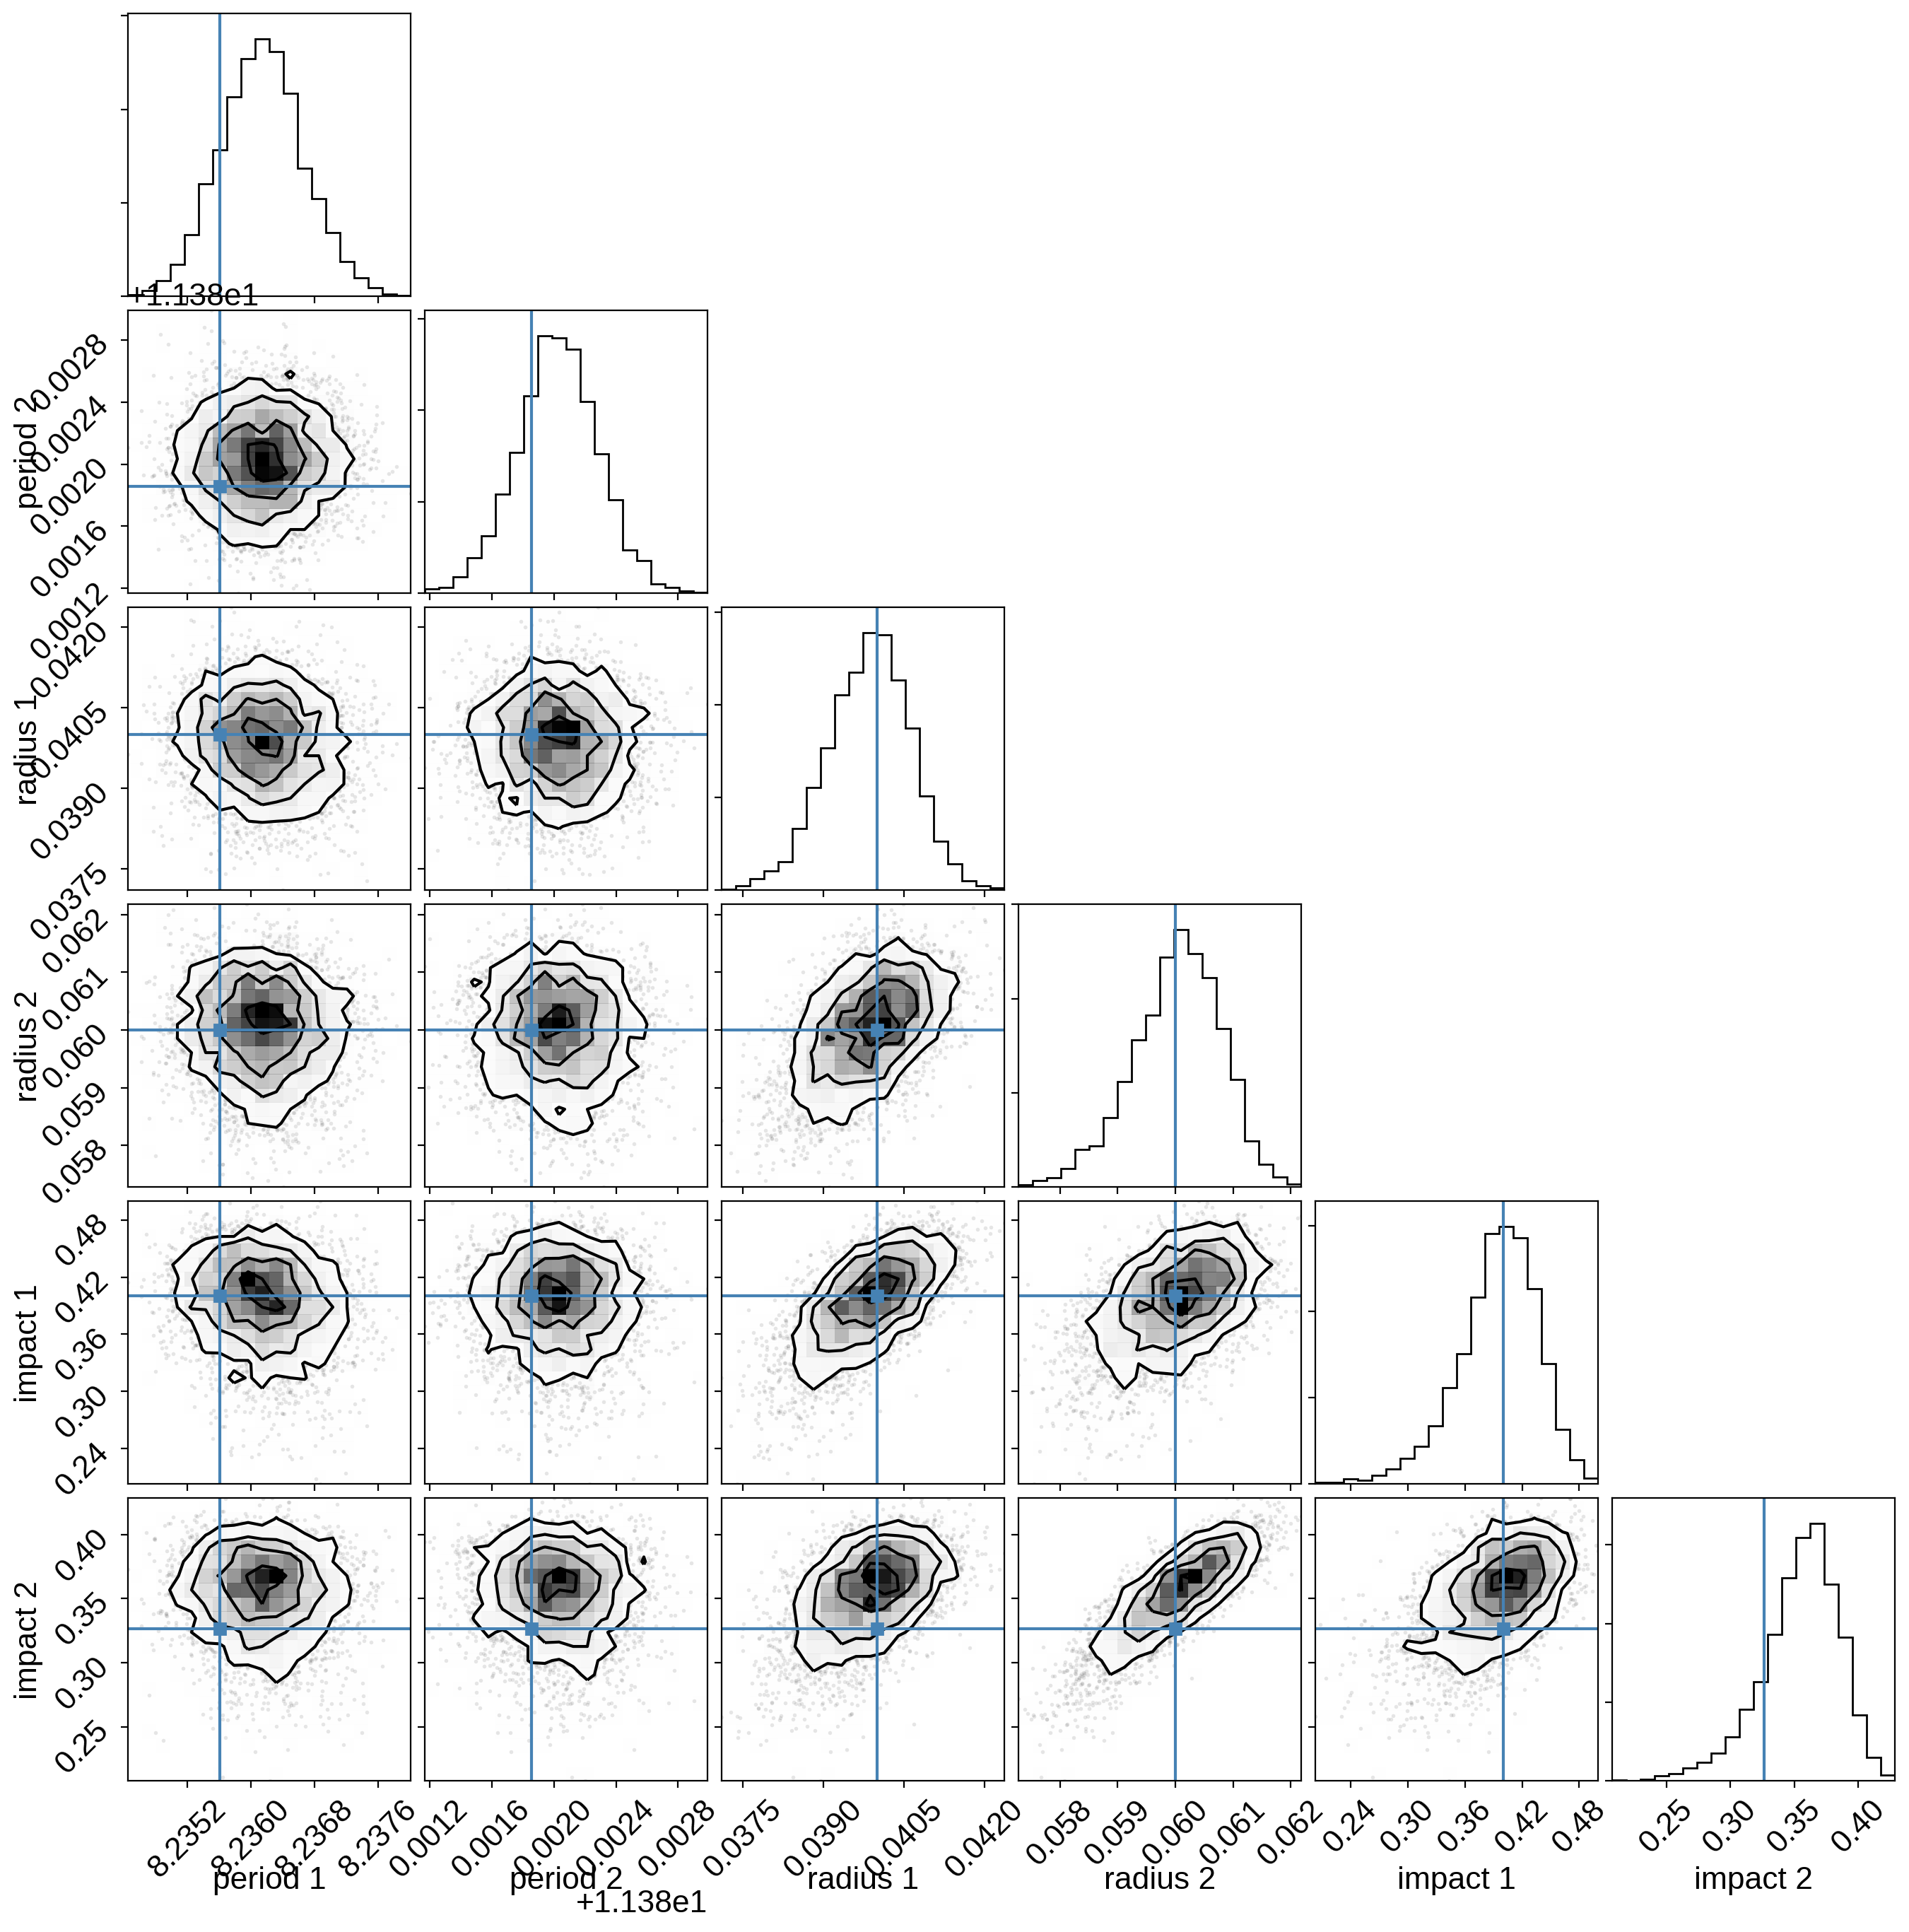

In [10]:
import corner

with model:
    truths = np.concatenate(
        list(map(np.atleast_1d, xo.eval_in_model([orbit.period, r, b])))
    )
samples = pm.trace_to_dataframe(trace, varnames=["period", "r", "b"])
corner.corner(
    samples,
    truths=truths,
    labels=["period 1", "period 2", "radius 1", "radius 2", "impact 1", "impact 2"],
);

We could also plot corner plots of the transit times, but they're not terribly enlightening in this case so let's skip it.

Finally, let's plot the posterior estimates of the the transit times in an O-C diagram:

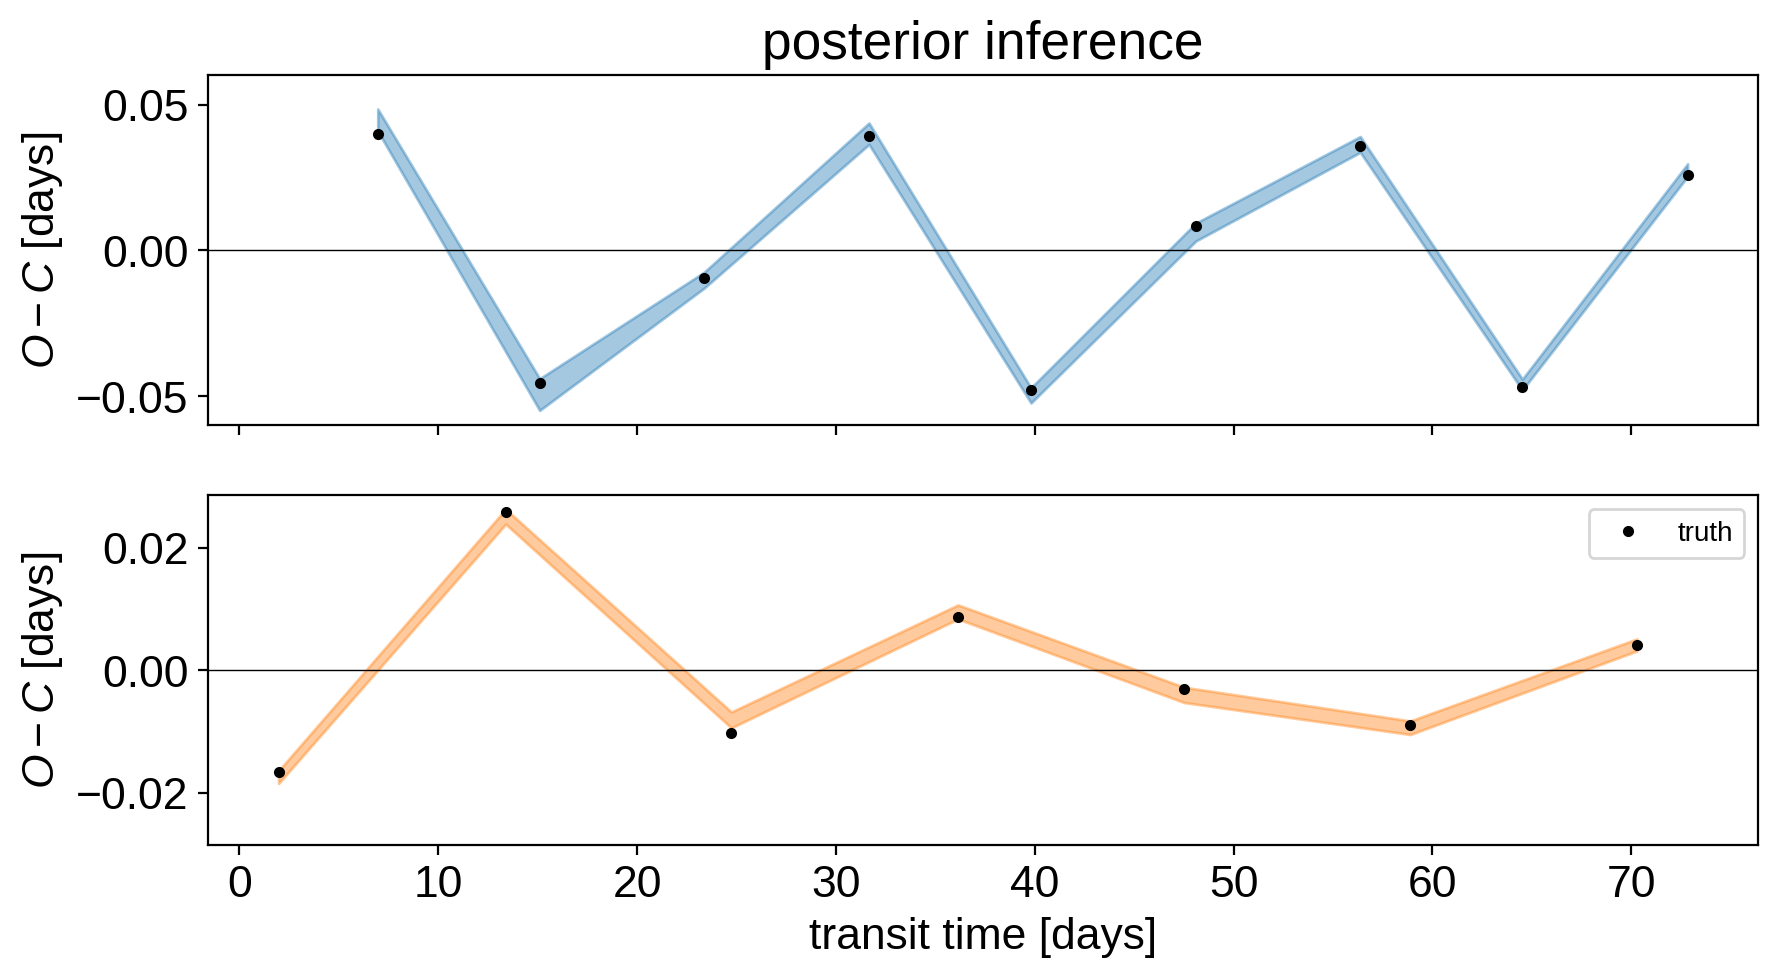

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

q = np.percentile(trace["ttvs_0"], [16, 50, 84], axis=0)
ax1.fill_between(
    np.mean(trace["tts_0"], axis=0), q[0], q[2], color="C0", alpha=0.4, edgecolor="none"
)
ref = np.polyval(
    np.polyfit(true_transit_times[0], true_ttvs[0], 1), true_transit_times[0]
)
ax1.plot(true_transit_times[0], true_ttvs[0] - ref, ".k")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [days]")

q = np.percentile(trace["ttvs_1"], [16, 50, 84], axis=0)
ax2.fill_between(
    np.mean(trace["tts_1"], axis=0), q[0], q[2], color="C1", alpha=0.4, edgecolor="none"
)
ref = np.polyval(
    np.polyfit(true_transit_times[1], true_ttvs[1], 1), true_transit_times[1]
)
ax2.plot(true_transit_times[1], true_ttvs[1] - ref, ".k", label="truth")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))

ax2.legend(fontsize=10)
ax2.set_ylabel("$O-C$ [days]")
ax2.set_xlabel("transit time [days]")
ax1.set_title("posterior inference");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
